# SY32 - Machine learning trafic sign detection

## 1 - Importation des libs

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import zipfile
from PIL import Image, ImageDraw, ImageFont, ImageColor
import csv
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix
from skimage.feature import hog
from skimage.transform import resize, rotate
from skimage.util import random_noise
from skimage.color import rgb2gray
from sklearn.pipeline import Pipeline
from skimage import exposure
import matplotlib.patches as patches
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import patches
import matplotlib.pyplot as plt
from collections import Counter
import random
import zipfile
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict

## 2 - Importation des dataset

In [3]:
TRAIN_IMAGES_DIR = "dataset-main/train/images"
TRAIN_LABELS_DIR = "dataset-main/train/labels"
VAL_IMAGES_DIR = "dataset-main/val/images"
VAL_LABELS_DIR = "dataset-main/val/labels"

def load_image(image_path):
    return cv2.imread(image_path)

def load_labels(label_path):
    labels = []
    try:
        df = pd.read_csv(label_path, header=None) 
        for _, row in df.iterrows():
            bbox = (row[0], row[1], row[2], row[3])
            class_id = row[4]
            if class_id != 'ff': 
                labels.append((bbox, class_id))
    except pd.errors.EmptyDataError:
        pass
    return labels

def load_dataset(images_dir, labels_dir):
    images, labels = [], []
    image_files = {os.path.splitext(f)[0]: os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg')}
    label_files = {os.path.splitext(f)[0]: os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.csv')}

    for base_name in sorted(image_files.keys()):
        if base_name in label_files:
            image = load_image(image_files[base_name])
            label = load_labels(label_files[base_name])
            images.append(image)
            labels.append(label)
        else:
            print(f"Pas de label trouvé pour {base_name}")

    return images, labels

In [4]:
train_images, train_labels = load_dataset(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR)
val_images, val_labels = load_dataset(VAL_IMAGES_DIR, VAL_LABELS_DIR)

In [5]:
# Images number in train/val dataset
print("Train :",len(train_labels), "Val :", len(val_labels))

Train : 703 Val : 87


## 3 - Extraction des zones d'intérêt + extraction features + augmentation des images

In [6]:
def hog_feature_extractor(image_gray):
    winSize = (96, 96)
    blockSize = (16, 16) 
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 12
    resize_img_hogcv2=cv2.resize(image_gray, winSize)


    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, _nbins=nbins)
    hog_features = hog.compute(resize_img_hogcv2, winStride=(8, 8), padding=(0, 0))
    return hog_features

def color_histogram_extractor(img):
    hist_R = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_G = cv2.calcHist([img], [1], None, [256], [0, 256])
    hist_B = cv2.calcHist([img], [2], None, [256], [0, 256])
    
    hist_R_normalized = hist_R / hist_R.sum()
    hist_G_normalized = hist_G / hist_G.sum()
    hist_B_normalized = hist_B / hist_B.sum()
    
    normalized_hist = np.concatenate([hist_R_normalized, hist_G_normalized, hist_B_normalized]).flatten()
    
    return normalized_hist

In [7]:
def extract_features(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    img_resized = cv2.resize(image, (64,64))
    image_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    hog_features = hog_feature_extractor(image_gray)    

    combined_features = hog_features
    return combined_features

In [9]:
def augment_images_and_extract_features(image):
    resized_image = resize(image, (64,64))
    augmented_images = [
        resized_image,
        random_noise(resized_image),
    ]

    features = []
    for img in augmented_images:
        features_result = extract_features(img)
        features.append(features_result)
    return features

In [10]:
def extract_window(image, bbox, size=(64, 64), scale_factor=1.5):
    x_min, y_min, x_max, y_max = bbox
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min

    window_width = bbox_width
    window_height = bbox_height

    while window_width < size[0] or window_height < size[1]:
        window_width *= scale_factor
        window_height *= scale_factor

    window_width = int(window_width)
    window_height = int(window_height)

    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2

    start_x = max(center_x - window_width // 2, 0)
    end_x = start_x + window_width
    if end_x > image.shape[1]:
        end_x = image.shape[1]
        start_x = end_x - window_width

    start_y = max(center_y - window_height // 2, 0)
    end_y = start_y + window_height
    if end_y > image.shape[0]:
        end_y = image.shape[0]
        start_y = end_y - window_height

    window = image[start_y:end_y, start_x:end_x]
    resized_window = resize(window, size)

    return resized_window
    
def preprocess_images_and_labels(images, labels, size=(64, 64)):
    X, y = [], []

    for img, lbl in zip(images, labels):
        bboxes = [(x, y, x2, y2) for (x, y, x2, y2), _ in lbl]
        
        if len(lbl) != 0:            
            for bbox, class_id in lbl:
                window = extract_window(img, bbox, size=size)
                if window.size != 0:
                    features = augment_images_and_extract_features(window)
                    X.extend(features)
                    y.extend([class_id] * len(features))

    final_class_counts = Counter(y)
    for cls, count in final_class_counts.items():
        print(f"Class {cls}: {count} images")
        
    return np.array(X), np.array(y)

In [11]:
X_train = []
y_train = []
X_val = []
y_val = []

# Preprocessing datasets
print("Train")
X_train_signs, y_train_signs = preprocess_images_and_labels(train_images, train_labels)

print("Val")
X_val_signs, y_val_signs = preprocess_images_and_labels(val_images, val_labels)

Train
Class frouge: 180 images
Class ceder: 266 images
Class interdiction: 730 images
Class fvert: 218 images
Class stop: 200 images
Class obligation: 216 images
Class danger: 324 images
Class forange: 134 images
Val
Class frouge: 26 images
Class interdiction: 88 images
Class ceder: 32 images
Class obligation: 32 images
Class stop: 28 images
Class danger: 38 images
Class forange: 12 images
Class fvert: 4 images


In [12]:
print(X_train_signs.shape)
print(y_train_signs.shape)

(2268, 5808)
(2268,)


## 4 - Récupération des images vides déjà enregistrées et triées

In [13]:
def load_images_treated(path_folder):
    X_false_pos=[]
    y_false_pos=[]
    list_files=os.listdir(path_folder)
    for file in list_files:
        img=cv2.imread(os.path.join(path_folder,file))
        if img is None:
            print('error in loading image', os.path.join(path_folder,file))
            continue
        image_resized=cv2.resize(img, (64,64))
        feature=extract_features(image_resized)
        X_false_pos.append(feature)
        y_false_pos.append(0)
    X_false_pos=np.array(X_false_pos)
    y_false_pos=np.array(y_false_pos)
    return X_false_pos,y_false_pos

In [14]:
path_empty="negative_samples"
X_empty,y_empty=load_images_treated(path_empty)

error in loading image negative_samples/.DS_Store


In [15]:
print(X_empty.shape)
print(y_empty.shape)

(2844, 5808)
(2844,)


## 5 - Finaliser la préparation des dataset pour le modèle

In [16]:
random.shuffle(X_empty)
X_train=np.concatenate([X_train_signs,X_empty[:1200]])
y_train=np.concatenate([y_train_signs,y_empty[:1200]])

X_val=np.concatenate([X_val_signs,X_empty[1200:1300]])
y_val=np.concatenate([y_val_signs,y_empty[1200:1300]])

In [17]:
print(X_train.shape)
print(y_train.shape)

(3468, 5808)
(3468,)


In [18]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

## 6 - Entrainement du modèle

Validation Accuracy: 0.6361111111111111
Confusion Matrix:
 [[92  0  0  0  0  4  4  0  0]
 [12 19  0  0  0  0  1  0  0]
 [15  0 21  0  0  0  2  0  0]
 [ 6  0  0  0  0  1  5  0  0]
 [13  1  1  0  3  0  8  0  0]
 [ 2  0  0  0  0  1  1  0  0]
 [25  0  1  0  0  0 62  0  0]
 [ 8  0  0  0  0  2 12 10  0]
 [ 6  0  0  0  0  0  1  0 21]]


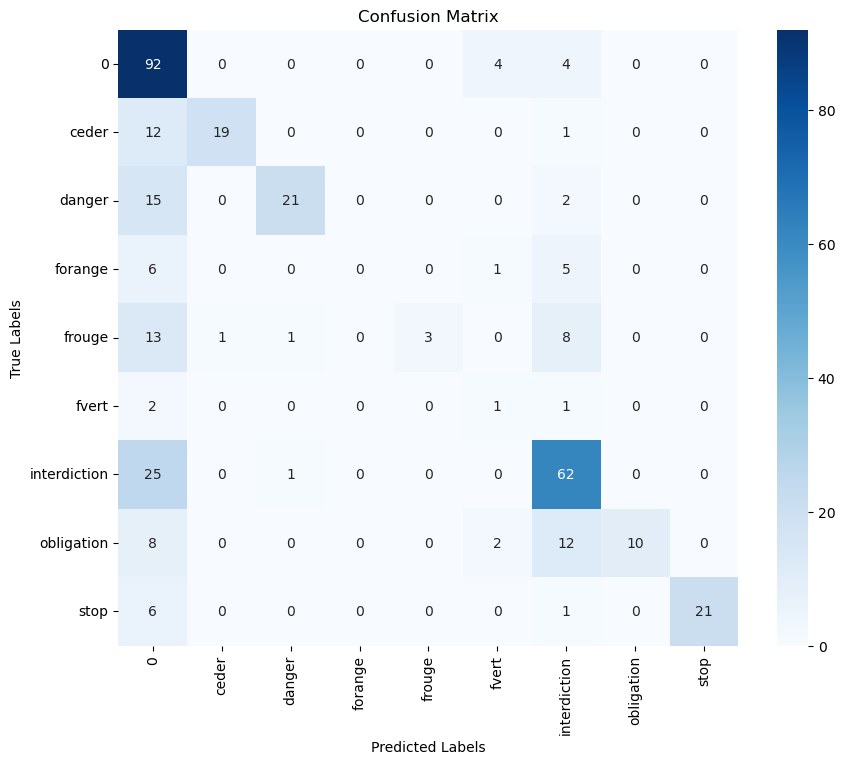

In [19]:
pipeline_binary = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', OneVsRestClassifier(SVC(probability=True, C=10, gamma=0.001, kernel="rbf")))
])

pipeline_binary.fit(X_train, y_train_encoded)

y_pred_val = pipeline_binary.predict(X_val)
validation_accuracy = accuracy_score(y_val_encoded, y_pred_val)
print("Validation Accuracy:", validation_accuracy)

conf_matrix = confusion_matrix(y_val_encoded, y_pred_val)
print("Confusion Matrix:\n", conf_matrix)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 7 - Détecter les panneaux de signalisation

In [20]:
def IoU(box1, box2):

  x_left = max(box1[0], box2[0])
  y_top = max(box1[1], box2[1])
  x_right = min(box1[2], box2[2])
  y_bottom = min(box1[3], box2[3])

  if x_right < x_left or y_bottom < y_top:
    return 0.0
  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
  union_area = box1_area + box2_area - intersection_area

  iou = intersection_area / union_area
  return iou


def non_max_suppression(results_in, tresh_iou = 0.01):
    if len(results_in)==0:
        return np.empty((0,5))
    i_removed=0
    results_out = np.empty((0,5)) # initialiser un tableau de sortie vide
    results_in_i = results_in[results_in[:,4].argsort()[::-1]]
    results_out_i = np.empty((0,5))
    results_out_i = np.vstack((results_out_i, results_in_i[0]))
    for n in range(1,len(results_in_i)):
        for m in range(len(results_out_i)):
            if IoU(results_in_i[n,0:4], results_out_i[m,0:4]) > tresh_iou:
                i_removed+=1
                break
            elif m == len(results_out_i)-1:
                results_out_i = np.vstack((results_out_i, results_in_i[n]))
    results_out = np.vstack((results_out,results_out_i))
    return results_out

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def image_pyramid(image, scale=1.5, min_size=(64, 64)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        if w < min_size[0] or h < min_size[1]:
            break
        image = cv2.resize(image, (w, h))
        yield image


def detect_objects(image, pipeline, label_encoder, window_size=(64, 64), step_size=16, scale=1.5, confidence_threshold=0.9):
    detections = []
    current_scale = 1.0
    max_detections = {}

    for resized in image_pyramid(image, scale=scale):
        for (x, y, window) in sliding_window(resized, step_size, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            features = extract_features(window)
            predictions = pipeline.predict([features])
            class_label = label_encoder.inverse_transform(predictions)[0]
            confidence_score = pipeline.predict_proba([features]).max()
            
            if class_label != 0.0:
                x_original = int(x * current_scale)
                y_original = int(y * current_scale)
                x2_original = int((x + window_size[0]) * current_scale)
                y2_original = int((y + window_size[1]) * current_scale)
                detection = (x_original, y_original, x2_original, y2_original, confidence_score, class_label)

                # Store the detection if it exceeds the confidence threshold
                if confidence_score >= confidence_threshold:
                    detections.append(detection)
                
                # Always store the maximum confidence detection
                if class_label not in max_detections or max_detections[class_label][4] < confidence_score:
                    max_detections[class_label] = detection

        current_scale *= scale

    best_detection = None

    for detection in max_detections.values():
        if best_detection is None or detection[4] > best_detection[4]:
            if detection[4] >= 0.5:
                best_detection = detection

    if not detections and best_detection != None:
        detections = [best_detection]
        print(detections)


    if len(detections) > 0:
        boxes = np.array([[x1, y1, x2, y2, score] for (x1, y1, x2, y2, score, _) in detections])
        nms_boxes = non_max_suppression(boxes, tresh_iou=0.01)
        detections = [(int(x1), int(y1), int(x2), int(y2), score, class_label)
                      for (x1, y1, x2, y2, score), (_, _, _, _, _, class_label) in zip(nms_boxes, detections)]

    return detections


def plot_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    for (x1, y1, x2, y2, score, class_label) in detections:
        if class_label != 0.0:
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1 - 10, f'{class_label} ({score:.2f})', color='red', fontsize=12, weight='bold', backgroundcolor='white')
    plt.show()

In [ ]:
input_image_path = "dataset-main/val/images/0560.jpg"
input_image = cv2.imread(input_image_path)
detections = detect_objects(input_image, pipeline_binary, label_encoder)

plot_detections(input_image_path, detections)

for (x1, y1, x2, y2, score, class_label) in detections:
    print(f"Detected {class_label} at [{x1}, {y1}, {x2}, {y2}] with score {score}")

## 8 - Trouver des faux positifs sur le dataset train et réentrainer le modèle

False positives for image :  0
correct positives :  0
predicted boxes :  0


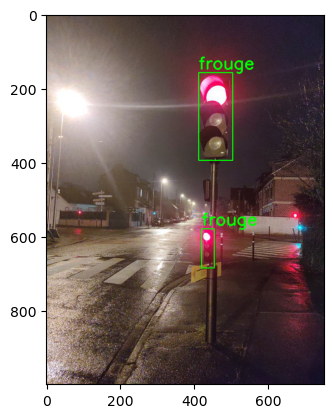

KeyboardInterrupt: 

In [83]:
X_false_pos=find_false_positives("dataset-main/train", pipeline)

In [69]:
def filter_true_positives(detections, true_bboxes, iou_threshold=0.5):
    false_positives = {}
    for n, det_list in detections.items():
        false_positives[n] = []
        for det in det_list:
            x, y, x2, y2, class_id, confidence = det
            det_bbox = (x, y, x2, y2)
            overlaps = [iou(det_bbox, true_bbox) for true_bbox in true_bboxes[n-1]]
            if not any(overlap >= iou_threshold for overlap in overlaps):
                false_positives[n].append(det)
    return false_positives

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


In [70]:
true_bboxes = []
for lbls in train_labels:
    true_bboxes.append([bbox for bbox, _ in lbls])

false_positives = filter_true_positives(train_detections, true_bboxes)

In [71]:
def preprocess_false_positives(false_positives, images, window_size):
    X_fp = []
    y_fp = []
    for n, det_list in false_positives.items():
        img = images[n-1]
        for (x, y, x2, y2, class_id, confidence) in det_list:
            patch = extract_window(img, (x, y, x2, y2), size=(64, 64))
            features = extract_features(patch, size=(64, 64), augment=False)
            X_fp.append(features[0])
            y_fp.append("empty")
    return np.array(X_fp), np.array(y_fp)


In [72]:
X_fp, y_fp = preprocess_false_positives(false_positives, train_images, window_size=(64, 64))

In [83]:
X_train_new = np.concatenate((X_train, X_fp))
y_train_new = np.concatenate((y_train, y_fp))

In [86]:
y_train_encoded_new = label_encoder.fit_transform(y_train_new)
y_val_encoded_new = label_encoder.transform(y_val)

In [120]:
pipeline_retrained = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', OneVsRestClassifier(SVC(probability=True, C=10, gamma=0.001, kernel="rbf", class_weight='balanced')))
])

pipeline_retrained.fit(X_train_new, y_train_encoded_new)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('classifier',
                 OneVsRestClassifier(estimator=SVC(C=10,
                                                   class_weight='balanced',
                                                   gamma=0.001,
                                                   probability=True)))])

In [121]:
y_pred_val = pipeline_retrained.predict(X_val)
validation_accuracy = accuracy_score(y_val_encoded_new, y_pred_val)
print("Validation Accuracy after retraining:", validation_accuracy)

Validation Accuracy after retraining: 0.801762114537445


Confusion Matrix:
 [[13  0  3  0  0  0  0  0  0]
 [ 0 15  4  0  0  0  0  0  0]
 [ 0  0 97  0  0  0  0  0  0]
 [ 0  0  5  1  0  0  0  0  0]
 [ 0  0  9  0  2  1  1  0  0]
 [ 0  0  1  0  0  1  0  0  0]
 [ 0  0 13  0  0  0 31  0  0]
 [ 0  0  5  0  0  0  3  8  0]
 [ 0  0  0  0  0  0  0  0 14]]


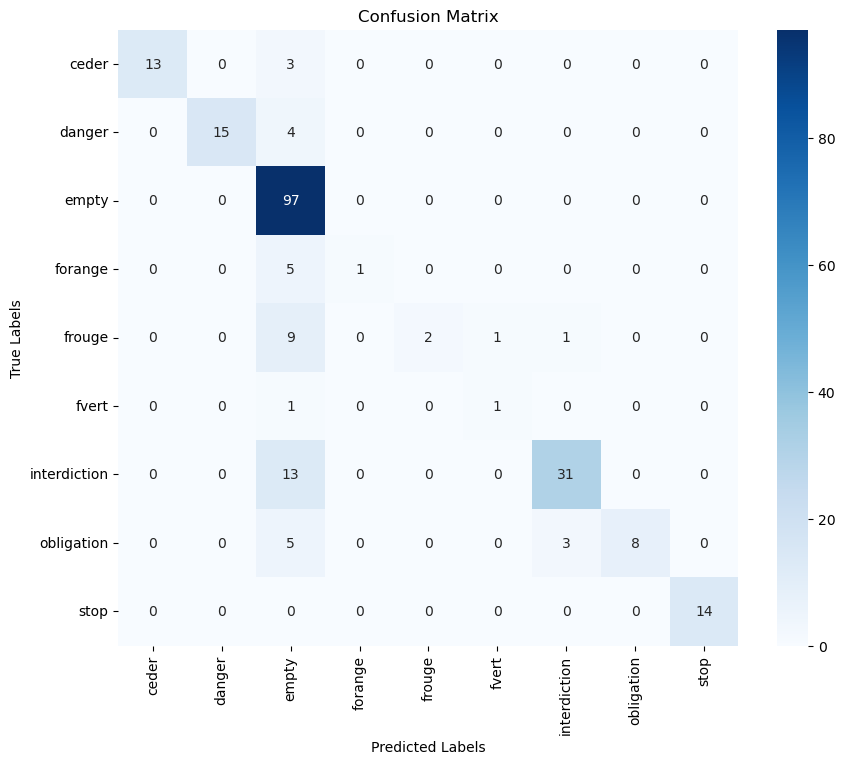

In [122]:
conf_matrix = confusion_matrix(y_val_encoded_new, y_pred_val)
print("Confusion Matrix:\n", conf_matrix)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 9 - On detecte les objets sur VAL et on créé le csv

In [118]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def image_pyramid(image, scale=1.5, min_size=(64, 64)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        if w < min_size[0] or h < min_size[1]:
            break
        image = cv2.resize(image, (w, h))
        yield image


def detect_objects(image, pipeline, label_encoder, window_size=(64, 64), step_size=16, scale=1.5, confidence_threshold=0):
    detections = []
    current_scale = 1.0
    max_detections = {}

    for resized in image_pyramid(image, scale=scale):
        for (x, y, window) in sliding_window(resized, step_size, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            features = preprocess_image(window, augment=False)
            predictions = pipeline.predict(features)
            class_label = label_encoder.inverse_transform(predictions)[0]
            confidence_score = pipeline.predict_proba(features).max()
            
            if class_label != "empty":
                x_original = int(x * current_scale)
                y_original = int(y * current_scale)
                x2_original = int((x + window_size[0]) * current_scale)
                y2_original = int((y + window_size[1]) * current_scale)
                detection = (x_original, y_original, x2_original, y2_original, confidence_score, class_label)

                # Store the detection if it exceeds the confidence threshold
                if confidence_score >= confidence_threshold:
                    detections.append(detection)
                
                # Always store the maximum confidence detection
                if class_label not in max_detections or max_detections[class_label][4] < confidence_score:
                    max_detections[class_label] = detection

        current_scale *= scale

    best_detection = None

    for detection in max_detections.values():
        if best_detection is None or detection[4] > best_detection[4]:
            if detection[4] >= 0.75:
                best_detection = detection

    if not detections:
        detections = [best_detection]


    if len(detections) > 0:
        boxes = np.array([[x1, y1, x2, y2, score] for (x1, y1, x2, y2, score, _) in detections])
        nms_boxes = non_max_suppression(boxes, tresh_iou=0.01)
        detections = [(int(x1), int(y1), int(x2), int(y2), score, class_label)
                      for (x1, y1, x2, y2, score), (_, _, _, _, _, class_label) in zip(nms_boxes, detections)]

    return detections


def plot_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    for (x1, y1, x2, y2, score, class_label) in detections:
        if class_label != 'empty':
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1 - 10, f'{class_label} ({score:.2f})', color='red', fontsize=12, weight='bold', backgroundcolor='white')
    plt.show()

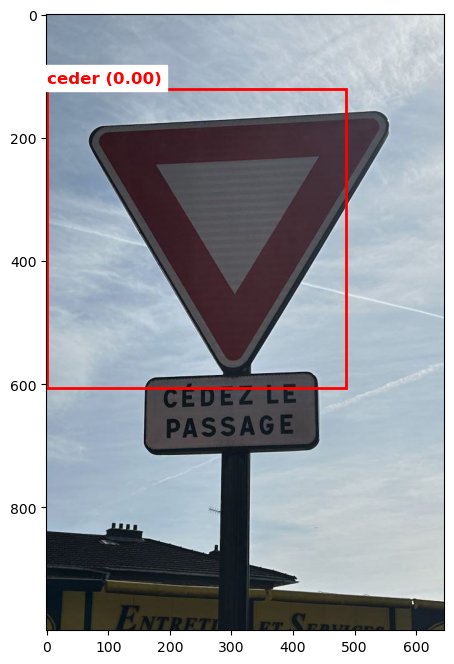

Detected ceder at [0, 121, 486, 607] with score 0


In [119]:
input_image_path = "dataset-main/val/images/0379.jpg"
input_image = cv2.imread(input_image_path)
detections = detect_objects(input_image, pipeline_retrained, label_encoder)

plot_detections(input_image_path, detections)

for (x1, y1, x2, y2, score, class_label) in detections:
    print(f"Detected {class_label} at [{x1}, {y1}, {x2}, {y2}] with score {score}")

In [123]:
def get_image_paths(val_dir):
    return [os.path.join(val_dir, fname) for fname in os.listdir(val_dir) if fname.endswith(('.jpg'))]

val_dir = "dataset-main/val/images"
image_paths = get_image_paths(val_dir)

all_detections = []

num = 0
for image_path in image_paths:
    input_image = cv2.imread(image_path)
    detections = detect_objects(input_image, pipeline_retrained, label_encoder)
    all_detections.append((image_path, detections))
    num = num+1
    print(image_path)
    print(num)

dataset-main/val/images/0717.jpg
1
dataset-main/val/images/0139.jpg
2
dataset-main/val/images/0878.jpg
3
dataset-main/val/images/0844.jpg
4
dataset-main/val/images/0272.jpg
5
dataset-main/val/images/0270.jpg
6
dataset-main/val/images/0846.jpg
7
dataset-main/val/images/0852.jpg
8
dataset-main/val/images/0711.jpg
9
dataset-main/val/images/0088.jpg
10
dataset-main/val/images/0248.jpg
11
dataset-main/val/images/0710.jpg
12
dataset-main/val/images/0698.jpg
13
dataset-main/val/images/0101.jpg
14
dataset-main/val/images/0263.jpg
15
dataset-main/val/images/0748.jpg
16
dataset-main/val/images/0576.jpg
17
dataset-main/val/images/0358.jpg
18
dataset-main/val/images/0827.jpg
19
dataset-main/val/images/0239.jpg
20
dataset-main/val/images/0039.jpg
21
dataset-main/val/images/0617.jpg
22
dataset-main/val/images/0831.jpg
23
dataset-main/val/images/0428.jpg
24
dataset-main/val/images/0560.jpg
25
dataset-main/val/images/0004.jpg
26
dataset-main/val/images/0766.jpg
27
dataset-main/val/images/0799.jpg
28
d

In [ ]:
data = [('dataset-main/test/0515.jpg', [(224, 368, 288, 432, 0.8336102878248052, 'interdiction'), (72, 540, 216, 684, 0.8233444840328885, 'interdiction'), (216, 600, 312, 696, 0.6245326811239501, 'interdiction'), (256, 704, 320, 768, 0.4890830668120111, 'interdiction'), (216, 456, 312, 552, 0.4664573687699748, 'frouge'), (0, 608, 64, 672, 0.4398480701882753, 'interdiction'), (72, 756, 216, 900, 0.4290060743160224, 'interdiction')]), ('dataset-main/test/0501.jpg', [(432, 270, 648, 486, 0.8480644744053406, 'interdiction'), (432, 176, 496, 240, 0.8245362043754727, 'danger'), (72, 408, 168, 504, 0.7729025049760464, 'danger'), (32, 544, 96, 608, 0.6471530088959643, 'danger'), (792, 36, 936, 180, 0.6208110292467844, 'danger'), (640, 192, 704, 256, 0.5932558502523838, 'danger'), (816, 288, 912, 384, 0.5844420086065685, 'interdiction'), (64, 624, 128, 688, 0.5659995789022911, 'interdiction'), (48, 880, 112, 944, 0.535753314156071, 'interdiction'), (0, 656, 64, 720, 0.48796823998510813, 'danger'), (168, 288, 264, 384, 0.4810085577910672, 'interdiction'), (48, 288, 144, 384, 0.44527457963815525, 'interdiction'), (504, 72, 648, 216, 0.43664883248495967, 'fvert'), (48, 0, 144, 96, 0.405178544331184, 'ceder')]), ('dataset-main/test/0313.jpg', [(432, 270, 648, 486, 0.8934165226048265, 'danger'), (648, 324, 864, 540, 0.8764166709709218, 'interdiction'), (112, 512, 176, 576, 0.8500760825394127, 'interdiction'), (888, 240, 984, 336, 0.8022607811823046, 'interdiction'), (416, 656, 480, 720, 0.7633578967848939, 'interdiction'), (480, 120, 576, 216, 0.7602556175918906, 'danger'), (560, 576, 624, 640, 0.748576338640933, 'interdiction'), (128, 208, 192, 272, 0.7404450615033584, 'interdiction'), (400, 544, 464, 608, 0.7366596865163227, 'danger'), (176, 288, 240, 352, 0.7159907220556695, 'interdiction'), (288, 552, 384, 648, 0.7030093052936607, 'danger'), (352, 32, 416, 96, 0.6992907675353176, 'danger'), (840, 0, 936, 96, 0.6958350006705263, 'interdiction'), (792, 744, 888, 840, 0.6922260081299391, 'danger'), (528, 24, 624, 120, 0.6899578020942546, 'ceder'), (256, 432, 320, 496, 0.6684983837828435, 'interdiction'), (352, 688, 416, 752, 0.6445006053897671, 'interdiction'), (736, 48, 800, 112, 0.6399631815531266, 'interdiction'), (704, 176, 768, 240, 0.6220483146376755, 'interdiction'), (756, 540, 900, 684, 0.595603432296688, 'danger'), (192, 704, 256, 768, 0.5882263191038211, 'interdiction'), (880, 384, 944, 448, 0.588114087593903, 'ceder'), (648, 576, 744, 672, 0.5854331476340329, 'danger'), (96, 272, 160, 336, 0.5344448128430523, 'interdiction'), (192, 768, 288, 864, 0.5201525634054041, 'interdiction'), (752, 912, 816, 976, 0.5068555352536083, 'fvert'), (800, 176, 864, 240, 0.48316778297109186, 'interdiction'), (800, 848, 864, 912, 0.3693180763614457, 'interdiction'), (576, 720, 720, 864, 0.30041382688793417, 'interdiction')]), ('dataset-main/test/0475.jpg', [(208, 112, 272, 176, 0.7814866173921527, 'interdiction'), (162, 162, 486, 486, 0.7608633832561038, 'danger'), (416, 592, 480, 656, 0.7370676980806253, 'interdiction'), (48, 504, 144, 600, 0.7156501715901209, 'interdiction'), (384, 0, 480, 96, 0.677316640781442, 'interdiction'), (528, 192, 624, 288, 0.6522577900026711, 'interdiction'), (792, 72, 936, 216, 0.6278095812277306, 'interdiction'), (464, 144, 528, 208, 0.6185648543005703, 'interdiction'), (560, 96, 624, 160, 0.6150344918567378, 'interdiction'), (720, 64, 784, 128, 0.6108162990603256, 'interdiction'), (880, 528, 944, 592, 0.5959107683615367, 'interdiction'), (648, 378, 864, 594, 0.5670534918701841, 'fvert'), (888, 336, 984, 432, 0.5432876312528362, 'danger'), (288, 80, 352, 144, 0.5366456664174468, 'interdiction'), (224, 528, 288, 592, 0.5260194502680057, 'interdiction'), (656, 112, 720, 176, 0.517172750370665, 'danger'), (32, 224, 96, 288, 0.4595531577542205, 'interdiction'), (112, 272, 176, 336, 0.4581088248234484, 'interdiction'), (144, 496, 208, 560, 0.44899032184885984, 'interdiction'), (416, 672, 480, 736, 0.43639699661664066, 'frouge'), (48, 144, 112, 208, 0.4260777963754317, 'interdiction'), (216, 600, 312, 696, 0.4128361604099391, 'frouge'), (468, 432, 612, 576, 0.3009254683281446, 'interdiction'), (48, 0, 112, 64, 0.2788910821969509, 'interdiction')]), ('dataset-main/test/0449.jpg', [(448, 640, 512, 704, 0.8005315569392135, 'interdiction'), (312, 288, 408, 384, 0.7922994386394361, 'interdiction'), (432, 324, 648, 540, 0.7760719302833042, 'interdiction'), (408, 216, 504, 312, 0.7511012116857595, 'danger'), (48, 544, 112, 608, 0.7458884091078013, 'interdiction'), (888, 0, 984, 96, 0.6932621042308462, 'danger'), (336, 24, 432, 120, 0.6761378882466094, 'interdiction'), (672, 624, 736, 688, 0.6589112251609741, 'interdiction'), (272, 224, 336, 288, 0.6498685324972945, 'danger'), (224, 480, 288, 544, 0.5889262477948034, 'interdiction'), (272, 160, 336, 224, 0.5795724396813815, 'interdiction'), (208, 640, 272, 704, 0.46204815720088455, 'interdiction'), (756, 576, 900, 720, 0.44956654409646185, 'interdiction')]), ('dataset-main/test/0474.jpg', [(96, 0, 192, 96, 0.6910679319413224, 'interdiction'), (848, 224, 912, 288, 0.6904847670687624, 'danger'), (540, 396, 684, 540, 0.6575437530298804, 'danger'), (128, 144, 192, 208, 0.6123832713257008, 'danger'), (880, 416, 944, 480, 0.6030479900255462, 'interdiction'), (880, 336, 944, 400, 0.5919252336071449, 'ceder'), (736, 432, 800, 496, 0.5227412520616823, 'interdiction')]), ('dataset-main/test/0070.jpg', [(0, 121, 486, 607, 0.8858506305638265, 'interdiction'), (432, 928, 496, 992, 0.8569512684780127, 'interdiction'), (480, 544, 544, 608, 0.8271051242249438, 'interdiction'), (384, 672, 448, 736, 0.7997838655094006, 'interdiction'), (32, 32, 96, 96, 0.7952789332481848, 'interdiction'), (480, 432, 544, 496, 0.7631764748194171, 'interdiction'), (528, 320, 592, 384, 0.7618246548050721, 'interdiction'), (0, 720, 144, 864, 0.749809464310615, 'interdiction'), (496, 224, 560, 288, 0.7235740385948041, 'interdiction'), (496, 128, 560, 192, 0.720029485425994, 'interdiction'), (144, 896, 208, 960, 0.6817061268575962, 'interdiction'), (408, 816, 504, 912, 0.6811774245280021, 'interdiction'), (448, 736, 512, 800, 0.6652203359659392, 'interdiction'), (16, 864, 80, 928, 0.6611662424037232, 'interdiction'), (304, 928, 368, 992, 0.6599675272296245, 'interdiction'), (112, 592, 176, 656, 0.6432680763062647, 'interdiction'), (480, 32, 544, 96, 0.6393406016564676, 'fvert'), (464, 336, 528, 400, 0.6351846758130205, 'interdiction'), (272, 640, 336, 704, 0.6335352391841086, 'fvert'), (464, 672, 528, 736, 0.6289610429201982, 'interdiction'), (0, 592, 64, 656, 0.6259315703198044, 'interdiction'), (544, 928, 608, 992, 0.6036822116267521, 'interdiction'), (368, 64, 432, 128, 0.5652669674090975, 'interdiction'), (160, 768, 224, 832, 0.5232062179291331, 'danger'), (544, 864, 608, 928, 0.4921353661620866, 'danger'), (544, 432, 608, 496, 0.48918199828598663, 'danger'), (544, 544, 608, 608, 0.4639171945742855, 'fvert'), (336, 752, 400, 816, 0.46163570826516265, 'interdiction'), (528, 736, 592, 800, 0.46118410773466884, 'interdiction'), (528, 672, 592, 736, 0.4527956862989671, 'interdiction'), (336, 608, 400, 672, 0.4057701637382844, 'interdiction'), (304, 80, 368, 144, 0.24946881053630007, 'interdiction')]), ('dataset-main/test/0099.jpg', [(364, 486, 850, 972, 0.9211573192900331, 'danger'), (480, 264, 576, 360, 0.8415443661613397, 'danger'), (544, 448, 608, 512, 0.7943288286387387, 'danger'), (648, 336, 744, 432, 0.7340421203723231, 'danger'), (256, 784, 320, 848, 0.6984175379710497, 'danger'), (16, 432, 80, 496, 0.6757639482321773, 'interdiction'), (840, 864, 936, 960, 0.6547408423409624, 'interdiction'), (96, 608, 160, 672, 0.6441948755262018, 'danger'), (144, 744, 240, 840, 0.6012805084221333, 'interdiction'), (256, 896, 320, 960, 0.5793062000864283, 'interdiction'), (16, 816, 80, 880, 0.5079409355086384, 'danger'), (108, 162, 324, 378, 0.47635286046814507, 'interdiction')]), ('dataset-main/test/0310.jpg', [(896, 272, 960, 336, 0.929521472361757, 'interdiction'), (612, 324, 756, 468, 0.8958710329113432, 'danger'), (320, 336, 384, 400, 0.8332904339447913, 'danger'), (0, 304, 64, 368, 0.814325168003439, 'ceder'), (432, 128, 496, 192, 0.8130350691718092, 'interdiction'), (840, 360, 936, 456, 0.7422883263454915, 'interdiction'), (512, 144, 576, 208, 0.6528582819205256, 'interdiction'), (168, 312, 264, 408, 0.6354036287224248, 'interdiction'), (528, 400, 592, 464, 0.6096060633600872, 'interdiction'), (192, 432, 256, 496, 0.5935646676963527, 'interdiction'), (432, 352, 496, 416, 0.587739672066619, 'interdiction'), (312, 408, 408, 504, 0.5677287415473621, 'interdiction'), (912, 112, 976, 176, 0.5598165678525902, 'interdiction'), (16, 416, 80, 480, 0.5526177982970544, 'interdiction'), (384, 288, 448, 352, 0.5460953763472524, 'interdiction'), (120, 0, 216, 96, 0.5199510421601873, 'interdiction'), (752, 288, 816, 352, 0.3198981898211603, 'interdiction'), (16, 528, 80, 592, 0.3034980619850446, 'interdiction')]), ('dataset-main/test/0462.jpg', [(96, 720, 192, 816, 0.8207906803046024, 'interdiction'), (528, 720, 624, 816, 0.7426723821970596, 'danger'), (216, 672, 312, 768, 0.7382004867989883, 'danger'), (121, 121, 607, 607, 0.7292010600744865, 'danger'), (600, 48, 696, 144, 0.7107880239098064, 'ceder'), (36, 576, 180, 720, 0.7027521522285238, 'interdiction'), (600, 552, 696, 648, 0.6844655664067543, 'interdiction'), (624, 320, 688, 384, 0.6801863628382796, 'danger'), (416, 592, 480, 656, 0.6689535506791564, 'danger'), (160, 816, 224, 880, 0.6332202114931026, 'danger'), (112, 80, 176, 144, 0.608454925895012, 'interdiction'), (208, 896, 272, 960, 0.42678025658421026, 'interdiction'), (288, 0, 384, 96, 0.42207326664083883, 'interdiction')]), ('dataset-main/test/0113.jpg', [(324, 0, 540, 216, 0.8773863672468739, 'danger'), (400, 368, 464, 432, 0.8565373992923349, 'interdiction'), (320, 576, 384, 640, 0.8433321221617002, 'interdiction'), (552, 360, 648, 456, 0.840464031405684, 'interdiction'), (432, 552, 528, 648, 0.8374590351074265, 'interdiction'), (656, 320, 720, 384, 0.8122154328640497, 'danger'), (528, 576, 592, 640, 0.8054899659207424, 'interdiction'), (216, 216, 312, 312, 0.7828146695820605, 'danger'), (624, 128, 688, 192, 0.7522454433119277, 'danger'), (72, 36, 216, 180, 0.7490102088564885, 'interdiction'), (528, 240, 592, 304, 0.7397913473926399, 'interdiction'), (168, 648, 264, 744, 0.7355500468508916, 'interdiction'), (288, 512, 352, 576, 0.7216940119232037, 'danger'), (544, 640, 608, 704, 0.6853618219086636, 'interdiction'), (368, 656, 432, 720, 0.6598285302707594, 'interdiction'), (544, 496, 608, 560, 0.6502609946167709, 'danger'), (240, 32, 304, 96, 0.6463257066746166, 'interdiction'), (736, 272, 800, 336, 0.6420173821161372, 'interdiction'), (0, 496, 64, 560, 0.6264917402748447, 'interdiction'), (704, 512, 768, 576, 0.6136215517901502, 'danger'), (16, 256, 80, 320, 0.5964346163807511, 'interdiction'), (688, 112, 752, 176, 0.5932687438184296, 'interdiction'), (72, 468, 216, 612, 0.5789060085036868, 'danger'), (672, 240, 736, 304, 0.5481612827888082, 'interdiction'), (16, 704, 80, 768, 0.5450439128007791, 'danger'), (368, 720, 432, 784, 0.5231094069624623, 'interdiction'), (80, 240, 144, 304, 0.4958023270623205, 'interdiction'), (560, 720, 624, 784, 0.43947888559189574, 'interdiction'), (720, 672, 784, 736, 0.4272471131653348, 'interdiction'), (624, 640, 688, 704, 0.2910805884912817, 'interdiction')]), ('dataset-main/test/0488.jpg', [(736, 272, 800, 336, 0.7316456815820052, 'ceder'), (576, 416, 640, 480, 0.6769087062425658, 'interdiction'), (252, 396, 396, 540, 0.6469874135706547, 'interdiction'), (448, 464, 512, 528, 0.6243528441043672, 'danger')]), ('dataset-main/test/0701.jpg', [(784, 448, 848, 512, 0.8233034540117028, 'interdiction'), (656, 384, 720, 448, 0.805015376604498, 'interdiction'), (752, 336, 816, 400, 0.7722482429073481, 'danger'), (552, 432, 648, 528, 0.7281661214388673, 'interdiction'), (352, 448, 416, 512, 0.7083242916365631, 'interdiction'), (896, 432, 960, 496, 0.6779424018277411, 'danger'), (800, 272, 864, 336, 0.6587506393139839, 'danger'), (672, 456, 768, 552, 0.6399647792970835, 'danger'), (256, 432, 320, 496, 0.554431497693146, 'danger'), (456, 408, 552, 504, 0.4670960913467592, 'interdiction'), (176, 352, 240, 416, 0.3916324575047852, 'interdiction')]), ('dataset-main/test/0739.jpg', [(312, 408, 408, 504, 0.8949490443095194, 'interdiction'), (528, 336, 592, 400, 0.7565687016103687, 'interdiction'), (528, 528, 624, 624, 0.7336590644197194, 'fvert'), (272, 336, 336, 400, 0.729620948301188, 'interdiction'), (16, 400, 80, 464, 0.6972295516437534, 'interdiction'), (80, 336, 144, 400, 0.6904799623258031, 'danger'), (176, 368, 240, 432, 0.6630361095121645, 'interdiction'), (208, 464, 272, 528, 0.6482895365969757, 'interdiction'), (624, 480, 688, 544, 0.590813129596759, 'interdiction'), (544, 624, 608, 688, 0.5710571683018875, 'danger'), (656, 48, 720, 112, 0.526293821521537, 'danger'), (432, 288, 496, 352, 0.512539624940967, 'danger'), (352, 512, 416, 576, 0.4803868230593712, 'danger'), (464, 512, 528, 576, 0.47478769868097465, 'fvert'), (528, 464, 592, 528, 0.34219846917439023, 'fvert'), (288, 592, 352, 656, 0.33632086028117714, 'danger')]), ('dataset-main/test/0063.jpg', [(448, 624, 512, 688, 0.8502571533452049, 'ceder'), (72, 864, 168, 960, 0.7577726074724903, 'interdiction'), (48, 576, 144, 672, 0.7300684356195727, 'fvert'), (0, 672, 96, 768, 0.7079105736030333, 'ceder'), (0, 480, 96, 576, 0.6914001546512943, 'danger'), (312, 456, 408, 552, 0.6761051496998357, 'danger'), (464, 800, 528, 864, 0.6730820499675872, 'danger'), (168, 840, 264, 936, 0.6581264637332754, 'danger'), (400, 784, 464, 848, 0.6458158460345839, 'interdiction'), (464, 448, 528, 512, 0.6448371777393573, 'interdiction'), (256, 560, 320, 624, 0.635325223508475, 'interdiction'), (480, 736, 544, 800, 0.6319435442343139, 'interdiction'), (0, 81, 324, 405, 0.6234518570962824, 'interdiction'), (64, 768, 128, 832, 0.6164750104671604, 'interdiction'), (336, 736, 400, 800, 0.5982075729697963, 'interdiction'), (48, 0, 112, 64, 0.5932565676270142, 'interdiction'), (288, 800, 352, 864, 0.4376247018218948, 'danger'), (240, 736, 304, 800, 0.2839807629609517, 'interdiction')]), ('dataset-main/test/0249.jpg', [(592, 432, 656, 496, 0.8021234909497729, 'interdiction'), (816, 432, 880, 496, 0.7972912383046572, 'interdiction'), (912, 400, 976, 464, 0.7561991312188577, 'interdiction'), (128, 448, 192, 512, 0.7241073603120565, 'interdiction'), (432, 396, 576, 540, 0.7038390380494381, 'fvert'), (736, 384, 800, 448, 0.6790194469422475, 'interdiction'), (608, 368, 672, 432, 0.6409369291012841, 'ceder'), (672, 432, 736, 496, 0.5574835729946459, 'danger'), (736, 448, 800, 512, 0.4707638010088871, 'ceder')]), ('dataset-main/test/0842.jpg', [(448, 448, 512, 512, 0.7904455317399581, 'interdiction'), (720, 432, 784, 496, 0.6663086706140561, 'danger'), (592, 448, 656, 512, 0.6612662022346382, 'interdiction'), (544, 368, 608, 432, 0.6600757744940339, 'interdiction'), (696, 336, 792, 432, 0.634756747451328, 'danger'), (512, 464, 576, 528, 0.5819081572665274, 'danger'), (832, 368, 896, 432, 0.5681939660601075, 'interdiction'), (928, 464, 992, 528, 0.5575251447743794, 'danger'), (756, 180, 900, 324, 0.4230460477696808, 'interdiction'), (144, 360, 288, 504, 0.39620326136178635, 'interdiction')]), ('dataset-main/test/0843.jpg', [(384, 192, 480, 288, 0.8431974297265395, 'danger'), (648, 0, 972, 324, 0.817216604254372, 'frouge'), (594, 486, 810, 702, 0.7349955017039429, 'fvert'), (608, 288, 672, 352, 0.705817145241149, 'fvert'), (408, 456, 504, 552, 0.6805070791006897, 'interdiction'), (384, 72, 480, 168, 0.6303116207115079, 'fvert'), (504, 0, 648, 144, 0.6072456951833152, 'danger'), (96, 72, 192, 168, 0.6040707397316225, 'danger'), (800, 912, 864, 976, 0.5947643261392517, 'interdiction'), (432, 702, 648, 918, 0.5039987917629699, 'danger'), (264, 72, 360, 168, 0.4752948294272003, 'interdiction'), (48, 600, 144, 696, 0.462833634268288, 'danger'), (48, 456, 144, 552, 0.45369037663537415, 'ceder'), (912, 928, 976, 992, 0.3432316164977387, 'ceder'), (576, 144, 640, 208, 0.3354195584496513, 'interdiction')]), ('dataset-main/test/0670.jpg', [(400, 608, 464, 672, 0.8061536039342503, 'interdiction'), (540, 504, 684, 648, 0.7586408694270975, 'interdiction'), (384, 888, 480, 984, 0.7405985960719215, 'interdiction'), (252, 36, 396, 180, 0.7312091282787819, 'fvert'), (176, 592, 240, 656, 0.7215136815251839, 'interdiction'), (480, 408, 576, 504, 0.7134022830274217, 'interdiction'), (304, 592, 368, 656, 0.6829865558514565, 'interdiction'), (672, 640, 736, 704, 0.666818833764988, 'interdiction'), (336, 720, 400, 784, 0.6583446980367536, 'interdiction'), (368, 464, 432, 528, 0.6417292786011458, 'interdiction'), (496, 688, 560, 752, 0.63332115081948, 'interdiction'), (112, 224, 176, 288, 0.605817967921517, 'interdiction'), (32, 624, 96, 688, 0.5851981543912369, 'interdiction'), (640, 320, 704, 384, 0.5777547868473767, 'interdiction'), (336, 528, 400, 592, 0.5674473783643702, 'interdiction'), (224, 256, 288, 320, 0.5377399588587719, 'interdiction'), (408, 192, 504, 288, 0.5311808655413702, 'interdiction'), (672, 448, 736, 512, 0.49545489443798657, 'interdiction'), (448, 544, 512, 608, 0.4949144687709182, 'interdiction'), (112, 592, 176, 656, 0.48757929400155325, 'interdiction'), (464, 608, 528, 672, 0.4844027785772908, 'interdiction'), (672, 704, 736, 768, 0.46951343216462255, 'interdiction'), (168, 408, 264, 504, 0.32961836664464195, 'interdiction'), (400, 736, 464, 800, 0.2923781746183276, 'interdiction')]), ('dataset-main/test/0314.jpg', [(96, 168, 192, 264, 0.8191548079316235, 'interdiction'), (384, 464, 448, 528, 0.7968410279261546, 'interdiction'), (486, 216, 702, 432, 0.7865191020702426, 'interdiction'), (736, 256, 800, 320, 0.7852527719168638, 'interdiction'), (816, 168, 912, 264, 0.7844569108278152, 'interdiction'), (736, 192, 800, 256, 0.7473359400661334, 'interdiction'), (16, 192, 80, 256, 0.7418645115999336, 'danger'), (160, 640, 224, 704, 0.729871875163996, 'interdiction'), (624, 48, 720, 144, 0.7259976032090311, 'interdiction'), (336, 336, 432, 432, 0.702209851381424, 'interdiction'), (288, 176, 352, 240, 0.6980898257358521, 'frouge'), (912, 352, 976, 416, 0.681900874520091, 'interdiction'), (800, 304, 864, 368, 0.6784052787147182, 'interdiction'), (400, 144, 464, 208, 0.6541560160188448, 'interdiction'), (336, 272, 400, 336, 0.5926758041755954, 'interdiction'), (408, 648, 504, 744, 0.5676864420699687, 'interdiction'), (400, 256, 464, 320, 0.5245365899681118, 'interdiction'), (720, 368, 784, 432, 0.45262307057244744, 'interdiction'), (16, 496, 80, 560, 0.38572174046528834, 'interdiction'), (848, 80, 912, 144, 0.34355060399557164, 'interdiction'), (912, 192, 976, 256, 0.3212865525590136, 'interdiction')]), ('dataset-main/test/0506.jpg', [(121, 0, 607, 486, 0.8845620298633255, 'danger'), (600, 672, 696, 768, 0.8033629570682589, 'danger'), (576, 848, 640, 912, 0.7699795792977531, 'interdiction'), (496, 848, 560, 912, 0.7647915595214229, 'interdiction'), (320, 672, 384, 736, 0.7489197317274107, 'fvert'), (378, 594, 594, 810, 0.7290485212943734, 'interdiction'), (288, 768, 384, 864, 0.7216191922043669, 'ceder'), (400, 512, 464, 576, 0.6623547567751584, 'interdiction'), (144, 672, 208, 736, 0.6557128192179514, 'fvert'), (208, 848, 272, 912, 0.5960648700524052, 'fvert'), (304, 864, 368, 928, 0.5699375932536425, 'interdiction'), (256, 704, 320, 768, 0.5618724315659493, 'danger'), (256, 592, 320, 656, 0.5468423692135113, 'interdiction'), (384, 816, 480, 912, 0.5185216686503243, 'danger'), (64, 928, 128, 992, 0.5081598925396178, 'interdiction'), (128, 864, 192, 928, 0.4076694475799838, 'interdiction'), (544, 912, 608, 976, 0.37962507763013664, 'interdiction')]), ('dataset-main/test/0074.jpg', [(304, 544, 368, 608, 0.8501096889764743, 'interdiction'), (182, 182, 911, 911, 0.8494022546966679, 'interdiction'), (560, 384, 624, 448, 0.8349639147709196, 'interdiction'), (192, 48, 288, 144, 0.8230243405551705, 'interdiction'), (752, 336, 816, 400, 0.8112281876755966, 'ceder'), (288, 0, 384, 96, 0.760591195115052, 'danger'), (32, 176, 96, 240, 0.7561301794729083, 'interdiction'), (768, 592, 832, 656, 0.7508439235062034, 'danger'), (128, 160, 192, 224, 0.7259921415963816, 'danger'), (96, 792, 192, 888, 0.6895483278773237, 'danger'), (896, 656, 960, 720, 0.6685148750114608, 'danger'), (288, 608, 352, 672, 0.6249440392117903, 'interdiction'), (0, 16, 64, 80, 0.616616871253584, 'interdiction'), (768, 912, 832, 976, 0.6091522598078114, 'interdiction'), (368, 608, 432, 672, 0.6006410757096692, 'interdiction'), (608, 176, 672, 240, 0.5701684809871417, 'danger'), (128, 16, 192, 80, 0.554658649035368, 'interdiction'), (144, 304, 208, 368, 0.5504380471010324, 'danger'), (48, 96, 112, 160, 0.5467379602889559, 'interdiction'), (48, 456, 144, 552, 0.5171573486594494, 'interdiction'), (208, 256, 272, 320, 0.4608698027241984, 'interdiction'), (880, 816, 944, 880, 0.45797365587854594, 'ceder'), (144, 528, 208, 592, 0.4561112697087892, 'danger'), (0, 896, 64, 960, 0.4481056727693466, 'interdiction'), (784, 160, 848, 224, 0.44579910892228936, 'interdiction'), (384, 144, 448, 208, 0.4368382452338136, 'interdiction'), (544, 624, 608, 688, 0.3968096608871337, 'danger'), (384, 864, 448, 928, 0.3599189789609737, 'interdiction'), (480, 160, 544, 224, 0.3526083629750517, 'interdiction'), (832, 0, 896, 64, 0.32771570489505214, 'interdiction'), (192, 800, 256, 864, 0.3217478027954785, 'danger'), (800, 464, 864, 528, 0.3031810403259858, 'interdiction'), (64, 240, 128, 304, 0.27858204721055063, 'ceder')]), ('dataset-main/test/0316.jpg', [(378, 486, 594, 702, 0.835191796783474, 'interdiction'), (656, 656, 720, 720, 0.8089536764762122, 'interdiction'), (576, 720, 720, 864, 0.6646710659722423, 'danger'), (378, 162, 594, 378, 0.6601065139866257, 'interdiction'), (400, 768, 464, 832, 0.6534253521628355, 'danger'), (672, 528, 736, 592, 0.6268418691249686, 'danger'), (576, 864, 672, 960, 0.605686603447558, 'danger'), (480, 64, 544, 128, 0.5742100224407428, 'interdiction'), (768, 144, 832, 208, 0.548890191729341, 'danger'), (800, 0, 864, 64, 0.4877808232891367, 'interdiction')]), ('dataset-main/test/0128.jpg', [(128, 496, 192, 560, 0.8670974949195642, 'interdiction'), (256, 512, 320, 576, 0.832214059234138, 'danger'), (48, 512, 112, 576, 0.8032763058874441, 'interdiction'), (192, 464, 256, 528, 0.7991092691720758, 'danger'), (36, 720, 180, 864, 0.7647675878506928, 'interdiction'), (128, 416, 192, 480, 0.6861880413198385, 'interdiction'), (108, 576, 252, 720, 0.5126748026167728, 'interdiction')]), ('dataset-main/test/0673.jpg', [(600, 480, 696, 576, 0.8149907118163865, 'interdiction'), (264, 456, 360, 552, 0.7817545916797638, 'fvert'), (608, 400, 672, 464, 0.772106187208462, 'interdiction'), (672, 416, 736, 480, 0.7343247669421862, 'forange'), (384, 416, 448, 480, 0.7194104501089489, 'interdiction'), (176, 288, 240, 352, 0.6918377349555815, 'interdiction'), (464, 656, 528, 720, 0.6913393201007381, 'interdiction'), (304, 384, 368, 448, 0.6762263066702029, 'danger'), (480, 448, 544, 512, 0.6643487688428339, 'interdiction'), (0, 384, 96, 480, 0.6459038956134177, 'frouge'), (384, 528, 480, 624, 0.5450083297484091, 'frouge'), (224, 384, 288, 448, 0.5373338697875687, 'interdiction'), (48, 528, 112, 592, 0.4504046358933082, 'interdiction'), (128, 416, 192, 480, 0.44488451491658937, 'fvert'), (512, 560, 576, 624, 0.4337975270305041, 'fvert'), (288, 560, 352, 624, 0.4110473530622372, 'danger'), (512, 368, 576, 432, 0.3972626758286828, 'interdiction'), (360, 624, 456, 720, 0.26940403123948653, 'interdiction')]), ('dataset-main/test/0471.jpg', [(288, 360, 432, 504, 0.8928529715240927, 'interdiction'), (320, 624, 384, 688, 0.8774682967615778, 'interdiction'), (576, 744, 672, 840, 0.7596718498112959, 'danger'), (368, 736, 432, 800, 0.7455567372609403, 'interdiction'), (320, 848, 384, 912, 0.7408838705832015, 'interdiction'), (264, 240, 360, 336, 0.7204534615758824, 'interdiction'), (176, 592, 240, 656, 0.6812404761070714, 'interdiction'), (672, 560, 736, 624, 0.6692108422604862, 'interdiction'), (48, 624, 144, 720, 0.6690157063256497, 'interdiction'), (464, 624, 528, 688, 0.6454642127584997, 'interdiction'), (320, 544, 384, 608, 0.6413163708493765, 'fvert'), (624, 880, 688, 944, 0.6175222631304342, 'interdiction'), (512, 496, 576, 560, 0.5919946119835492, 'interdiction'), (608, 496, 672, 560, 0.48886895063894603, 'interdiction'), (320, 928, 384, 992, 0.4605318868525961, 'interdiction'), (576, 144, 720, 288, 0.4531835489196604, 'interdiction'), (512, 32, 576, 96, 0.4524702438554411, 'interdiction'), (528, 848, 592, 912, 0.43947100030893815, 'danger'), (144, 416, 208, 480, 0.43628057612038423, 'interdiction'), (456, 264, 552, 360, 0.3461892184491663, 'interdiction')]), ('dataset-main/test/0459.jpg', [(576, 312, 672, 408, 0.8426127770321675, 'danger'), (192, 64, 256, 128, 0.8394883878192433, 'danger'), (600, 168, 696, 264, 0.825819485892, 'interdiction'), (288, 320, 352, 384, 0.7059981652914217, 'interdiction'), (840, 336, 936, 432, 0.6928835442907918, 'danger'), (736, 192, 800, 256, 0.6820600993920137, 'danger'), (208, 144, 272, 208, 0.6793021095663657, 'danger'), (120, 312, 216, 408, 0.6680790447936549, 'danger'), (768, 624, 832, 688, 0.6461063949702678, 'ceder'), (864, 216, 960, 312, 0.6221482522976117, 'danger'), (432, 360, 528, 456, 0.6217651847766847, 'ceder'), (688, 608, 752, 672, 0.583309959132971, 'frouge'), (624, 504, 720, 600, 0.5780724448721944, 'interdiction'), (208, 256, 272, 320, 0.5701004177996746, 'interdiction'), (784, 288, 848, 352, 0.432683517885277, 'interdiction')]), ('dataset-main/test/0539.jpg', [(384, 208, 448, 272, 0.857647497267682, 'interdiction'), (108, 288, 252, 432, 0.8534246501513345, 'interdiction'), (320, 528, 384, 592, 0.8402537996492867, 'danger'), (108, 432, 324, 648, 0.8180941046133168, 'danger'), (624, 816, 720, 912, 0.8045544820681746, 'ceder'), (72, 828, 216, 972, 0.8026394514232322, 'interdiction'), (648, 720, 744, 816, 0.7979294721801302, 'danger'), (378, 324, 594, 540, 0.7840169023167338, 'interdiction'), (624, 72, 720, 168, 0.7816353253284978, 'danger'), (912, 896, 976, 960, 0.7708794242974959, 'danger'), (888, 552, 984, 648, 0.7575428115594529, 'interdiction'), (512, 784, 576, 848, 0.751789752153011, 'interdiction'), (264, 48, 360, 144, 0.7427655135966592, 'ceder'), (864, 288, 960, 384, 0.7380323186312515, 'interdiction'), (264, 672, 360, 768, 0.7246174362075313, 'interdiction'), (320, 160, 384, 224, 0.7135729429821456, 'interdiction'), (0, 880, 64, 944, 0.7005007222094106, 'interdiction'), (256, 864, 320, 928, 0.6831011333321584, 'danger'), (736, 912, 800, 976, 0.6692501701310957, 'interdiction'), (816, 48, 912, 144, 0.6684632955764481, 'interdiction'), (912, 416, 976, 480, 0.653783745611259, 'interdiction'), (416, 768, 480, 832, 0.6508934523288402, 'interdiction'), (736, 176, 800, 240, 0.6438028541690307, 'danger'), (720, 252, 864, 396, 0.6285822196305026, 'ceder'), (640, 640, 704, 704, 0.6221080503377435, 'danger'), (80, 720, 144, 784, 0.6067086063686805, 'frouge'), (336, 912, 400, 976, 0.6028994620003305, 'danger'), (264, 768, 360, 864, 0.5869529068344052, 'interdiction'), (912, 736, 976, 800, 0.5770336704666562, 'interdiction'), (288, 256, 352, 320, 0.5754440392460727, 'interdiction'), (128, 224, 192, 288, 0.5666920003755517, 'interdiction'), (800, 912, 864, 976, 0.5596998060404786, 'interdiction'), (336, 592, 400, 656, 0.5342024371203286, 'interdiction'), (64, 208, 128, 272, 0.5271441288573631, 'interdiction'), (176, 752, 240, 816, 0.5266942339884639, 'interdiction'), (880, 224, 944, 288, 0.5137416251120805, 'danger'), (912, 80, 976, 144, 0.42869623419746533, 'interdiction'), (528, 168, 624, 264, 0.4145656518447536, 'ceder')]), ('dataset-main/test/0713.jpg', [(180, 36, 324, 180, 0.8310665375129823, 'ceder'), (600, 744, 696, 840, 0.8060275149426664, 'ceder'), (928, 480, 992, 544, 0.8016748350655948, 'danger'), (896, 416, 960, 480, 0.7657770680433602, 'danger'), (384, 896, 448, 960, 0.7330818977206455, 'danger'), (704, 640, 768, 704, 0.7055940309891454, 'danger'), (800, 432, 864, 496, 0.6546883785463167, 'interdiction'), (912, 256, 976, 320, 0.645494016142698, 'danger'), (162, 486, 486, 810, 0.6407996062890942, 'danger'), (576, 848, 640, 912, 0.6357079763209702, 'interdiction'), (496, 768, 560, 832, 0.6163170693829594, 'interdiction'), (832, 576, 896, 640, 0.6031715403778483, 'interdiction'), (64, 864, 128, 928, 0.5820097486380594, 'interdiction'), (512, 688, 576, 752, 0.5792750191496996, 'danger'), (0, 800, 64, 864, 0.5651022867838816, 'danger'), (176, 352, 240, 416, 0.5473851590794994, 'danger'), (128, 880, 192, 944, 0.5419615332119443, 'interdiction'), (480, 0, 576, 96, 0.3796739760469603, 'ceder'), (400, 432, 464, 496, 0.34753950668570754, 'interdiction')]), ('dataset-main/test/0198.jpg', [(270, 216, 486, 432, 0.7943659086464552, 'interdiction'), (704, 496, 768, 560, 0.7453661794802422, 'ceder'), (640, 384, 704, 448, 0.6382885765217, 'interdiction'), (792, 456, 888, 552, 0.6371409553495506, 'ceder'), (504, 360, 600, 456, 0.6113073925554415, 'danger'), (400, 528, 464, 592, 0.5981912855238657, 'interdiction'), (576, 108, 720, 252, 0.5709751888478098, 'interdiction'), (736, 240, 800, 304, 0.5549163092489844, 'danger'), (54, 54, 270, 270, 0.5309316310021646, 'danger'), (432, 828, 576, 972, 0.4391040224465372, 'interdiction'), (544, 608, 608, 672, 0.32464205323402623, 'interdiction')]), ('dataset-main/test/0629.jpg', [(160, 400, 224, 464, 0.8643008213380147, 'interdiction'), (288, 396, 432, 540, 0.8425967953224869, 'interdiction'), (480, 528, 544, 592, 0.7266253935438682, 'interdiction'), (80, 464, 144, 528, 0.7194470882504045, 'interdiction'), (54, 162, 270, 378, 0.6939344958122649, 'interdiction'), (432, 108, 648, 324, 0.6930350489110271, 'fvert'), (432, 352, 496, 416, 0.6511608147497034, 'interdiction'), (192, 480, 256, 544, 0.6136855181900731, 'interdiction'), (0, 368, 64, 432, 0.6091889171124449, 'fvert'), (608, 384, 672, 448, 0.5917348199880144, 'frouge'), (608, 464, 672, 528, 0.548643866550894, 'interdiction'), (54, 540, 270, 756, 0.47516410637516354, 'frouge'), (672, 384, 736, 448, 0.46759020316488636, 'obligation'), (432, 432, 528, 528, 0.4404166557813606, 'interdiction')]), ('dataset-main/test/0173.jpg', [(96, 320, 160, 384, 0.8505565083334461, 'ceder'), (288, 240, 352, 304, 0.8484284464255315, 'danger'), (176, 272, 240, 336, 0.8049857382275925, 'interdiction'), (304, 320, 368, 384, 0.7449942015382112, 'interdiction'), (304, 384, 368, 448, 0.5998496781910727, 'interdiction'), (0, 336, 64, 400, 0.5783760415762217, 'interdiction'), (240, 304, 304, 368, 0.4785302539457602, 'ceder')]), ('dataset-main/test/0601.jpg', [(432, 756, 576, 900, 0.8537405641322008, 'interdiction'), (192, 840, 288, 936, 0.7786808955675112, 'interdiction'), (16, 752, 80, 816, 0.7474740939255741, 'interdiction'), (112, 736, 176, 800, 0.6831029993881478, 'interdiction'), (288, 880, 352, 944, 0.6588166639657859, 'interdiction'), (576, 912, 640, 976, 0.6459432475836171, 'danger'), (128, 656, 192, 720, 0.6171386085800874, 'interdiction'), (464, 928, 528, 992, 0.5979728122236122, 'interdiction'), (352, 608, 416, 672, 0.5710678543878862, 'interdiction'), (112, 864, 176, 928, 0.5693031003679117, 'fvert'), (432, 480, 528, 576, 0.5553669513286404, 'interdiction'), (144, 432, 208, 496, 0.4290223774871403, 'interdiction'), (216, 744, 312, 840, 0.415693287650872, 'interdiction'), (352, 720, 416, 784, 0.32467703925367425, 'danger')]), ('dataset-main/test/0165.jpg', [(432, 378, 648, 594, 0.9096180684065875, 'interdiction'), (432, 162, 648, 378, 0.8379399066075517, 'interdiction'), (752, 224, 816, 288, 0.8070468895400147, 'frouge'), (432, 0, 576, 144, 0.8013079867712047, 'interdiction'), (928, 400, 992, 464, 0.8009257252464053, 'interdiction'), (648, 324, 864, 540, 0.8007060354629915, 'ceder'), (912, 496, 976, 560, 0.7826421332443162, 'interdiction'), (696, 624, 792, 720, 0.7797672975884253, 'interdiction'), (352, 304, 416, 368, 0.7379124065986199, 'danger'), (160, 192, 224, 256, 0.7333853038754062, 'danger'), (256, 432, 320, 496, 0.7176226568930036, 'interdiction'), (24, 576, 120, 672, 0.7119619705428372, 'interdiction'), (408, 624, 504, 720, 0.7101141771327062, 'interdiction'), (252, 540, 396, 684, 0.7026740695625471, 'interdiction'), (144, 640, 208, 704, 0.6603433178147037, 'interdiction'), (0, 144, 144, 288, 0.6460587737698075, 'interdiction'), (120, 360, 216, 456, 0.6206379454749485, 'interdiction'), (192, 272, 256, 336, 0.6005270662003388, 'interdiction'), (96, 48, 192, 144, 0.5882360885503156, 'interdiction'), (288, 108, 432, 252, 0.5869461411192177, 'interdiction'), (320, 448, 384, 512, 0.5534040286869327, 'interdiction'), (144, 528, 208, 592, 0.4196539891615061, 'interdiction'), (864, 416, 928, 480, 0.3677751871816629, 'fvert')]), ('dataset-main/test/0603.jpg', [(480, 312, 576, 408, 0.8144003277065555, 'interdiction'), (336, 192, 400, 256, 0.7829773790424064, 'interdiction'), (36, 144, 180, 288, 0.7813730933682106, 'interdiction'), (640, 448, 704, 512, 0.7015962414505321, 'interdiction'), (416, 80, 480, 144, 0.6790987296191088, 'interdiction'), (160, 80, 224, 144, 0.6667346172921281, 'interdiction'), (240, 32, 304, 96, 0.6375991607851409, 'interdiction'), (752, 448, 816, 512, 0.6271267488962001, 'interdiction'), (288, 128, 352, 192, 0.5770189716961153, 'interdiction'), (64, 288, 128, 352, 0.5633261652031968, 'interdiction'), (208, 160, 272, 224, 0.5315732653023276, 'interdiction'), (96, 80, 160, 144, 0.42737888569168675, 'fvert')]), ('dataset-main/test/0789.jpg', [(160, 400, 224, 464, 0.8791706749054582, 'interdiction'), (480, 0, 544, 64, 0.8635301819824469, 'interdiction'), (432, 324, 648, 540, 0.8359401747467349, 'interdiction'), (0, 416, 64, 480, 0.8258117982181103, 'danger'), (288, 496, 352, 560, 0.8005768286212237, 'interdiction'), (656, 416, 720, 480, 0.7923221302297666, 'fvert'), (24, 288, 120, 384, 0.7541244870873958, 'interdiction'), (162, 0, 486, 324, 0.7355191139293233, 'interdiction'), (368, 336, 432, 400, 0.6858532382634678, 'frouge'), (112, 464, 176, 528, 0.6706385686276278, 'frouge'), (64, 384, 128, 448, 0.636251659447515, 'danger'), (368, 512, 432, 576, 0.6296502261911244, 'frouge'), (252, 792, 396, 936, 0.6064563686473269, 'frouge'), (512, 128, 576, 192, 0.6019234013235133, 'interdiction'), (224, 464, 288, 528, 0.511733611861766, 'frouge'), (656, 320, 720, 384, 0.4646914568557755, 'interdiction'), (368, 448, 432, 512, 0.4366782963171962, 'interdiction'), (288, 400, 352, 464, 0.39508920043275586, 'interdiction'), (304, 336, 368, 400, 0.34091689093035155, 'interdiction')]), ('dataset-main/test/0174.jpg', [(216, 456, 312, 552, 0.9319720252297886, 'interdiction'), (352, 608, 416, 672, 0.7954274075691811, 'interdiction'), (320, 528, 384, 592, 0.74897950414669, 'interdiction'), (192, 552, 288, 648, 0.4547273002149187, 'interdiction')]), ('dataset-main/test/0606.jpg', [(792, 396, 936, 540, 0.8613680317300555, 'interdiction'), (832, 272, 896, 336, 0.7932517160621658, 'interdiction'), (456, 432, 552, 528, 0.7121131876992124, 'interdiction'), (54, 378, 270, 594, 0.6992682586806017, 'interdiction'), (720, 672, 784, 736, 0.6920582113333665, 'ceder'), (720, 528, 784, 592, 0.6219472033331249, 'interdiction'), (928, 512, 992, 576, 0.6113969307877729, 'interdiction'), (744, 24, 840, 120, 0.5837739168745943, 'interdiction'), (208, 288, 272, 352, 0.5715399723456426, 'interdiction'), (360, 408, 456, 504, 0.5433793236543254, 'frouge'), (896, 256, 960, 320, 0.4826801783868105, 'frouge'), (640, 368, 704, 432, 0.4360784962525881, 'interdiction'), (704, 288, 768, 352, 0.36672006197683155, 'interdiction')]), ('dataset-main/test/0407.jpg', [(336, 640, 400, 704, 0.805717569884347, 'interdiction'), (252, 468, 396, 612, 0.7920702786982372, 'interdiction'), (16, 528, 80, 592, 0.7883680800906833, 'interdiction'), (432, 480, 496, 544, 0.7435533529846188, 'interdiction'), (96, 528, 160, 592, 0.7209662091751272, 'interdiction'), (176, 528, 240, 592, 0.689408027370283, 'interdiction'), (480, 552, 576, 648, 0.6869641154502052, 'interdiction'), (672, 736, 736, 800, 0.6789599234850743, 'interdiction'), (432, 270, 648, 486, 0.6661553847290117, 'interdiction'), (48, 464, 112, 528, 0.6538200814583268, 'frouge'), (256, 640, 320, 704, 0.6422750021924157, 'fvert'), (0, 594, 216, 810, 0.6269271670570709, 'fvert'), (464, 688, 528, 752, 0.5892339913133428, 'interdiction'), (496, 192, 560, 256, 0.5875974276810837, 'fvert'), (600, 552, 696, 648, 0.4886196675568631, 'interdiction'), (144, 408, 240, 504, 0.4525989141067139, 'interdiction'), (256, 368, 320, 432, 0.43609884640615293, 'interdiction'), (400, 640, 464, 704, 0.41993331990696015, 'interdiction')]), ('dataset-main/test/0189.jpg', [(240, 264, 336, 360, 0.8701389464547207, 'danger'), (848, 208, 912, 272, 0.8493291725092766, 'fvert'), (744, 264, 840, 360, 0.792595258259662, 'fvert'), (504, 192, 600, 288, 0.784241365842295, 'interdiction'), (640, 400, 704, 464, 0.7308357465084633, 'interdiction'), (600, 168, 696, 264, 0.7192258793671337, 'interdiction'), (912, 336, 976, 400, 0.7170340605391626, 'interdiction'), (704, 592, 768, 656, 0.7107094868249472, 'interdiction'), (672, 288, 736, 352, 0.6618728948983283, 'interdiction'), (720, 656, 784, 720, 0.6503222696782193, 'interdiction'), (144, 48, 208, 112, 0.6421988507650725, 'interdiction'), (24, 264, 120, 360, 0.6417320428597374, 'interdiction'), (720, 96, 816, 192, 0.6340135192665547, 'interdiction'), (784, 192, 848, 256, 0.5797829801200121, 'interdiction'), (408, 168, 504, 264, 0.5673708419530754, 'interdiction'), (720, 192, 784, 256, 0.5638334932051653, 'interdiction'), (576, 400, 640, 464, 0.5251321818380662, 'interdiction'), (432, 336, 496, 400, 0.5061612840925157, 'interdiction'), (432, 272, 496, 336, 0.4944095337293864, 'interdiction'), (120, 288, 216, 384, 0.49199022638416084, 'interdiction'), (560, 304, 624, 368, 0.47212149535515335, 'interdiction'), (912, 224, 976, 288, 0.39146480645636617, 'interdiction'), (128, 400, 192, 464, 0.3272387809984713, 'interdiction')]), ('dataset-main/test/0374.jpg', [(0, 216, 216, 432, 0.7647528603964419, 'interdiction'), (432, 252, 576, 396, 0.7626541700525089, 'frouge'), (464, 128, 528, 192, 0.7508421062960565, 'fvert'), (304, 112, 368, 176, 0.7484341057215816, 'frouge'), (704, 256, 768, 320, 0.7384473930082045, 'fvert'), (144, 112, 208, 176, 0.7093926152216987, 'fvert'), (600, 120, 696, 216, 0.6972365678642578, 'frouge'), (336, 208, 400, 272, 0.6926816927546148, 'danger'), (256, 288, 320, 352, 0.6798290221269137, 'fvert'), (624, 320, 688, 384, 0.6589920351006154, 'interdiction'), (800, 416, 864, 480, 0.6360921121584528, 'interdiction'), (336, 320, 400, 384, 0.567299648889797, 'interdiction'), (864, 304, 928, 368, 0.5586206321943121, 'interdiction'), (832, 192, 896, 256, 0.5212177023789811, 'interdiction'), (216, 168, 312, 264, 0.44354464245320036, 'interdiction'), (912, 208, 976, 272, 0.3535972182857641, 'forange')]), ('dataset-main/test/0360.jpg', [(320, 304, 384, 368, 0.7786274671098639, 'interdiction'), (128, 448, 192, 512, 0.7045665436864905, 'ceder'), (480, 320, 544, 384, 0.6920061305851704, 'danger'), (480, 624, 544, 688, 0.6838130596507279, 'interdiction'), (240, 256, 304, 320, 0.6828544505124351, 'interdiction'), (480, 416, 544, 480, 0.665067168992477, 'danger'), (0, 416, 64, 480, 0.6639157098256073, 'frouge'), (192, 336, 288, 432, 0.6347220517456569, 'interdiction'), (224, 432, 288, 496, 0.604664324495398, 'interdiction'), (416, 368, 480, 432, 0.5768057896500546, 'interdiction'), (304, 432, 368, 496, 0.5647608212359159, 'frouge'), (384, 432, 448, 496, 0.5566461242841496, 'danger')]), ('dataset-main/test/0557.jpg', [(160, 48, 224, 112, 0.8582569133466424, 'danger'), (396, 432, 540, 576, 0.8456702993173218, 'danger'), (336, 168, 432, 264, 0.7967338710232658, 'danger'), (48, 176, 112, 240, 0.7732321334549136, 'danger'), (592, 576, 656, 640, 0.6830711138965562, 'danger'), (180, 324, 324, 468, 0.6688781092270307, 'interdiction'), (560, 432, 624, 496, 0.6123462555456587, 'interdiction'), (80, 304, 144, 368, 0.6053339120309642, 'interdiction'), (640, 480, 704, 544, 0.6028027201179438, 'interdiction'), (16, 368, 80, 432, 0.598742009609835, 'interdiction'), (112, 112, 176, 176, 0.5532509323361819, 'fvert'), (496, 336, 560, 400, 0.532685030204501, 'fvert'), (80, 368, 144, 432, 0.47168652374372483, 'interdiction'), (48, 112, 112, 176, 0.46202531801381436, 'interdiction'), (272, 224, 336, 288, 0.40447786098595956, 'fvert'), (192, 480, 256, 544, 0.32258315159441203, 'interdiction')]), ('dataset-main/test/0153.jpg', [(405, 162, 729, 486, 0.8868004972391267, 'interdiction'), (504, 552, 600, 648, 0.8244781490187288, 'danger'), (160, 560, 224, 624, 0.8077226472022608, 'interdiction'), (162, 270, 378, 486, 0.8035363192406361, 'interdiction'), (592, 480, 656, 544, 0.7154541321116266, 'interdiction'), (528, 64, 592, 128, 0.7076686566335998, 'danger'), (480, 480, 544, 544, 0.7022406761046753, 'interdiction'), (240, 544, 304, 608, 0.6747799312184607, 'interdiction'), (96, 560, 160, 624, 0.667237377536608, 'interdiction'), (656, 912, 720, 976, 0.6597844105163556, 'interdiction'), (224, 608, 288, 672, 0.6456155639528246, 'interdiction'), (144, 120, 240, 216, 0.5838032770017726, 'interdiction'), (72, 264, 168, 360, 0.5295284218579429, 'fvert'), (456, 840, 552, 936, 0.5187527931578385, 'interdiction'), (32, 560, 96, 624, 0.43578328745649325, 'interdiction')]), ('dataset-main/test/0436.jpg', [(252, 396, 396, 540, 0.8490336831169518, 'danger'), (112, 784, 176, 848, 0.8411237499511612, 'danger'), (80, 864, 144, 928, 0.8047109738055723, 'danger'), (144, 648, 240, 744, 0.7968506838101138, 'fvert'), (192, 256, 256, 320, 0.7834211284673862, 'fvert'), (336, 288, 400, 352, 0.7534855385302198, 'fvert'), (216, 792, 360, 936, 0.7323021537472882, 'interdiction'), (560, 352, 624, 416, 0.7296229963193082, 'fvert'), (640, 352, 704, 416, 0.6946005023719227, 'fvert'), (240, 144, 304, 208, 0.6890051764486568, 'danger'), (400, 576, 464, 640, 0.6798089198081587, 'interdiction'), (272, 544, 336, 608, 0.6743378339253774, 'interdiction'), (0, 504, 144, 648, 0.6613354954758667, 'interdiction'), (192, 480, 256, 544, 0.6489910560210492, 'fvert'), (160, 416, 224, 480, 0.6488952863869818, 'fvert'), (608, 464, 672, 528, 0.6277562623842832, 'fvert'), (480, 464, 544, 528, 0.584831496343555, 'interdiction'), (480, 400, 544, 464, 0.5339819061294165, 'interdiction'), (416, 448, 480, 512, 0.5294242741270374, 'interdiction'), (272, 704, 336, 768, 0.48151465108187996, 'frouge'), (272, 608, 336, 672, 0.442924786860047, 'interdiction'), (144, 848, 208, 912, 0.4323795897499551, 'interdiction'), (432, 752, 496, 816, 0.36130615518451303, 'interdiction'), (48, 736, 112, 800, 0.260096811913692, 'fvert')]), ('dataset-main/test/0838.jpg', [(304, 416, 368, 480, 0.9101187495876567, 'danger'), (272, 672, 336, 736, 0.8460753967140516, 'interdiction'), (192, 432, 288, 528, 0.7936107542472746, 'interdiction'), (144, 608, 208, 672, 0.7808826222091715, 'interdiction'), (360, 600, 456, 696, 0.7772730494140407, 'fvert'), (96, 336, 192, 432, 0.748370171828783, 'interdiction'), (54, 108, 270, 324, 0.7172429641514557, 'interdiction'), (600, 504, 696, 600, 0.7150198670917645, 'interdiction'), (400, 48, 464, 112, 0.705530073430161, 'interdiction'), (288, 312, 384, 408, 0.7043643686781375, 'frouge'), (672, 160, 736, 224, 0.6988766875162634, 'interdiction'), (368, 128, 432, 192, 0.6967314219509507, 'frouge'), (256, 752, 320, 816, 0.6820659921541371, 'interdiction'), (288, 0, 352, 64, 0.6808661311255054, 'interdiction'), (304, 480, 368, 544, 0.6794422979722605, 'frouge'), (432, 336, 528, 432, 0.6565037928447793, 'interdiction'), (576, 624, 640, 688, 0.631646112694756, 'interdiction'), (432, 768, 496, 832, 0.6106255195864212, 'interdiction'), (448, 496, 512, 560, 0.599676923667927, 'interdiction'), (512, 496, 576, 560, 0.596788926714586, 'interdiction'), (192, 720, 256, 784, 0.5913130931282198, 'interdiction'), (224, 352, 288, 416, 0.5794870066432395, 'interdiction'), (464, 608, 528, 672, 0.562744311105661, 'interdiction'), (448, 240, 512, 304, 0.5415729739135768, 'interdiction'), (32, 576, 96, 640, 0.5387774664945061, 'interdiction'), (144, 16, 208, 80, 0.5163695399930264, 'interdiction'), (128, 528, 192, 592, 0.51385918353749, 'frouge'), (208, 0, 272, 64, 0.48482438057391347, 'interdiction'), (400, 432, 464, 496, 0.42983425526446517, 'interdiction'), (560, 784, 624, 848, 0.4218137386005151, 'frouge'), (112, 448, 176, 512, 0.39254540404471755, 'interdiction'), (368, 224, 432, 288, 0.35667854985762365, 'frouge'), (336, 64, 400, 128, 0.33609336035011045, 'interdiction'), (272, 576, 336, 640, 0.30532120133712604, 'frouge')]), ('dataset-main/test/0390.jpg', [(594, 54, 810, 270, 0.9216567904732461, 'interdiction'), (816, 624, 880, 688, 0.8681817796987383, 'ceder'), (880, 624, 944, 688, 0.8545989424832635, 'danger'), (792, 432, 936, 576, 0.8175172583916577, 'interdiction'), (696, 456, 792, 552, 0.7634945563964796, 'danger'), (784, 688, 848, 752, 0.7626357109555825, 'danger'), (432, 144, 528, 240, 0.7618929792975843, 'interdiction'), (400, 736, 464, 800, 0.7527922480672755, 'danger'), (928, 128, 992, 192, 0.6837365313582257, 'fvert'), (496, 240, 560, 304, 0.6641726951167566, 'fvert'), (704, 800, 768, 864, 0.652760182424806, 'ceder'), (160, 752, 224, 816, 0.6396861114736994, 'danger'), (880, 784, 944, 848, 0.6312985672063606, 'fvert'), (648, 288, 744, 384, 0.5877043294499799, 'fvert'), (528, 736, 592, 800, 0.5767737383122282, 'ceder'), (688, 912, 752, 976, 0.5743425682743711, 'danger'), (928, 16, 992, 80, 0.547873523540997, 'danger'), (672, 736, 736, 800, 0.5192333262698307, 'interdiction'), (0, 176, 64, 240, 0.48085125637812964, 'interdiction'), (224, 752, 288, 816, 0.4326671868960037, 'interdiction'), (672, 560, 736, 624, 0.4199466623230783, 'interdiction'), (320, 752, 384, 816, 0.3776028287317541, 'interdiction')]), ('dataset-main/test/0435.jpg', [(208, 336, 272, 400, 0.8328830539608395, 'interdiction'), (240, 216, 336, 312, 0.8220887439324742, 'interdiction'), (624, 304, 688, 368, 0.8066060843134736, 'interdiction'), (176, 496, 240, 560, 0.8052203201757491, 'danger'), (288, 336, 352, 400, 0.7776395911596624, 'interdiction'), (396, 288, 540, 432, 0.777400991505439, 'interdiction'), (752, 64, 816, 128, 0.7586958945288279, 'frouge'), (208, 560, 272, 624, 0.7217389149495256, 'danger'), (128, 224, 192, 288, 0.6714196045611166, 'interdiction'), (560, 320, 624, 384, 0.6539270670781665, 'interdiction'), (608, 384, 672, 448, 0.6434745167527217, 'interdiction'), (32, 336, 96, 400, 0.6299914499781537, 'fvert'), (848, 528, 912, 592, 0.6023860857402646, 'obligation'), (608, 240, 672, 304, 0.5998148239758556, 'fvert'), (272, 544, 336, 608, 0.5449796263224252, 'obligation'), (0, 224, 64, 288, 0.5184849650359714, 'interdiction'), (96, 368, 160, 432, 0.4999949889013944, 'interdiction'), (672, 400, 736, 464, 0.4009490845222039, 'interdiction')]), ('dataset-main/test/0582.jpg', [(400, 480, 464, 544, 0.7608853448305899, 'danger'), (612, 0, 756, 144, 0.7346371143831883, 'interdiction'), (702, 270, 918, 486, 0.6994306883020095, 'interdiction'), (336, 432, 400, 496, 0.5902372216641116, 'interdiction'), (408, 384, 504, 480, 0.590199193877705, 'interdiction'), (72, 324, 216, 468, 0.588241500538311, 'interdiction'), (240, 456, 336, 552, 0.44479141578471665, 'interdiction')]), ('dataset-main/test/0227.jpg', [(243, 243, 729, 729, 0.8779673880519785, 'interdiction'), (208, 576, 272, 640, 0.785465561489996, 'interdiction'), (0, 612, 144, 756, 0.7254783428206056, 'interdiction'), (720, 752, 784, 816, 0.5578427271090562, 'danger'), (736, 464, 800, 528, 0.537333248051548, 'interdiction'), (752, 608, 816, 672, 0.47118298716470297, 'interdiction'), (144, 416, 208, 480, 0.4598229137786054, 'interdiction')]), ('dataset-main/test/0541.jpg', [(624, 656, 688, 720, 0.8214598233202065, 'interdiction'), (528, 880, 592, 944, 0.7788363095571557, 'interdiction'), (432, 264, 528, 360, 0.7210249589945592, 'danger'), (864, 816, 960, 912, 0.7142218413232208, 'danger'), (432, 768, 528, 864, 0.6781944289474061, 'obligation'), (468, 576, 612, 720, 0.6498982619033891, 'frouge'), (600, 768, 696, 864, 0.6411405481023371, 'frouge'), (896, 736, 960, 800, 0.6119160460349335, 'interdiction'), (216, 840, 312, 936, 0.6014644194607841, 'interdiction'), (696, 840, 792, 936, 0.5574616769204331, 'fvert')]), ('dataset-main/test/0743.jpg', [(288, 576, 432, 720, 0.8871993386125275, 'interdiction'), (320, 400, 384, 464, 0.8213558571397404, 'interdiction'), (432, 756, 648, 972, 0.7835080794204532, 'interdiction'), (480, 384, 544, 448, 0.7564537972093418, 'interdiction'), (0, 828, 144, 972, 0.6947683087118377, 'danger'), (544, 592, 608, 656, 0.6627830478384374, 'danger'), (160, 928, 224, 992, 0.6485422740514236, 'danger'), (360, 216, 504, 360, 0.4138249736949957, 'danger'), (288, 0, 384, 96, 0.3930646896350369, 'danger')]), ('dataset-main/test/0155.jpg', [(672, 304, 736, 368, 0.9008845323282795, 'danger'), (688, 368, 752, 432, 0.8109018212541831, 'danger'), (384, 432, 448, 496, 0.6994734674122495, 'danger'), (560, 480, 624, 544, 0.6824479888944458, 'danger'), (288, 368, 352, 432, 0.6520587521284157, 'danger'), (624, 456, 720, 552, 0.6350563845653862, 'interdiction'), (496, 480, 560, 544, 0.6219317734851758, 'interdiction'), (768, 48, 832, 112, 0.612743040070951, 'danger'), (240, 432, 304, 496, 0.5917484979573235, 'danger')]), ('dataset-main/test/0141.jpg', [(816, 928, 880, 992, 0.9077570341275778, 'interdiction'), (405, 486, 729, 810, 0.8783910900032225, 'interdiction'), (54, 594, 270, 810, 0.8562216057698503, 'interdiction'), (756, 594, 972, 810, 0.8038339491767151, 'interdiction'), (504, 72, 648, 216, 0.740538137291031, 'interdiction'), (504, 324, 648, 468, 0.7345632929771315, 'interdiction'), (0, 396, 144, 540, 0.660022373758163, 'danger'), (96, 816, 192, 912, 0.6529082111532434, 'interdiction'), (432, 128, 496, 192, 0.6458185782822068, 'interdiction'), (624, 256, 688, 320, 0.6334507301996659, 'interdiction'), (324, 792, 468, 936, 0.6330217937497059, 'interdiction'), (672, 880, 736, 944, 0.6279301996919109, 'interdiction'), (216, 840, 312, 936, 0.5914596519611895, 'interdiction'), (816, 432, 912, 528, 0.5631212484987498, 'danger'), (272, 400, 336, 464, 0.5609164549292135, 'interdiction'), (0, 888, 96, 984, 0.5554683692037278, 'interdiction'), (368, 96, 432, 160, 0.5403075763505519, 'interdiction'), (352, 640, 416, 704, 0.4966626338928994, 'interdiction'), (416, 400, 480, 464, 0.4924462028538998, 'interdiction'), (80, 112, 144, 176, 0.47765602055664463, 'interdiction'), (0, 816, 64, 880, 0.4457664156213713, 'interdiction'), (400, 256, 464, 320, 0.2943020948561427, 'interdiction'), (0, 544, 64, 608, 0.2673423917892664, 'fvert')]), ('dataset-main/test/0814.jpg', [(560, 704, 624, 768, 0.8563507381988986, 'ceder'), (468, 432, 612, 576, 0.8491464813077707, 'interdiction'), (336, 672, 400, 736, 0.847796669536619, 'interdiction'), (208, 16, 272, 80, 0.8234005132786442, 'interdiction'), (684, 144, 828, 288, 0.8175939475630261, 'interdiction'), (304, 192, 368, 256, 0.7514935871835243, 'danger'), (312, 432, 408, 528, 0.7324509642242212, 'ceder'), (80, 400, 144, 464, 0.7290153411359005, 'danger'), (768, 720, 832, 784, 0.7001874096642543, 'interdiction'), (416, 0, 480, 64, 0.6985522992764304, 'ceder'), (144, 240, 240, 336, 0.6835775458933859, 'interdiction'), (256, 736, 320, 800, 0.6771554288661137, 'ceder'), (720, 360, 864, 504, 0.6416456884927982, 'interdiction'), (624, 672, 688, 736, 0.6369633113600005, 'interdiction'), (456, 120, 552, 216, 0.6343850961615466, 'interdiction'), (16, 544, 80, 608, 0.6165539853505356, 'interdiction'), (648, 816, 744, 912, 0.577875311265478, 'danger'), (816, 624, 880, 688, 0.5776135110169247, 'danger'), (400, 224, 464, 288, 0.5570465567552053, 'interdiction'), (48, 320, 112, 384, 0.5550202927358029, 'danger'), (792, 816, 888, 912, 0.5487627838480562, 'fvert'), (240, 432, 304, 496, 0.5379135883979846, 'interdiction'), (840, 168, 936, 264, 0.5047324326624304, 'interdiction'), (352, 320, 416, 384, 0.47061609200500876, 'interdiction'), (816, 560, 880, 624, 0.46799513866127374, 'interdiction'), (864, 304, 928, 368, 0.46539247686835966, 'interdiction'), (160, 544, 224, 608, 0.4634977647604214, 'interdiction'), (32, 176, 96, 240, 0.4519384004253148, 'interdiction'), (112, 160, 176, 224, 0.4470932241849691, 'interdiction'), (264, 96, 360, 192, 0.423217027235142, 'interdiction'), (608, 48, 672, 112, 0.3780892874095899, 'interdiction'), (640, 352, 704, 416, 0.3764115719515701, 'interdiction'), (48, 744, 144, 840, 0.3550270437344458, 'interdiction'), (216, 336, 312, 432, 0.3271645362386404, 'interdiction'), (400, 848, 464, 912, 0.30616668377270106, 'danger')]), ('dataset-main/test/0828.jpg', [(736, 336, 800, 400, 0.8727739986354693, 'danger'), (752, 400, 816, 464, 0.7751077935551195, 'danger'), (928, 448, 992, 512, 0.7488508804405397, 'danger'), (656, 448, 720, 512, 0.7264965053767516, 'frouge'), (160, 112, 224, 176, 0.6811692789180149, 'interdiction'), (528, 432, 624, 528, 0.6780490743575928, 'ceder'), (816, 400, 880, 464, 0.6636063477488703, 'interdiction'), (416, 448, 480, 512, 0.6417453830002228, 'frouge'), (24, 336, 120, 432, 0.6414781869980207, 'interdiction'), (864, 480, 928, 544, 0.6311666614801912, 'interdiction'), (800, 464, 864, 528, 0.6011125544096046, 'interdiction'), (336, 496, 400, 560, 0.5821573653019317, 'danger'), (576, 352, 640, 416, 0.5288498671373439, 'fvert')]), ('dataset-main/test/0801.jpg', [(216, 324, 360, 468, 0.826805840769176, 'danger'), (0, 360, 144, 504, 0.7575009151058867, 'interdiction'), (480, 352, 544, 416, 0.7264279004357427, 'interdiction'), (416, 368, 480, 432, 0.6526269868608384, 'interdiction'), (384, 304, 448, 368, 0.641610798359809, 'fvert'), (176, 496, 240, 560, 0.6107552523434207, 'interdiction'), (304, 480, 368, 544, 0.6079048727300499, 'ceder'), (48, 528, 112, 592, 0.550762949372903, 'ceder'), (352, 240, 416, 304, 0.5076010443057956, 'interdiction'), (0, 54, 216, 270, 0.46367508453743467, 'interdiction'), (396, 432, 540, 576, 0.420342845548412, 'interdiction'), (240, 496, 304, 560, 0.3698685156019645, 'interdiction'), (448, 240, 512, 304, 0.32664314023823565, 'danger')]), ('dataset-main/test/0140.jpg', [(576, 216, 720, 360, 0.8630239035632095, 'interdiction'), (216, 216, 432, 432, 0.832356332639584, 'interdiction'), (576, 72, 672, 168, 0.7954216046212477, 'interdiction'), (168, 48, 264, 144, 0.7888429470150204, 'danger'), (0, 216, 216, 432, 0.7706286023523996, 'interdiction'), (256, 480, 320, 544, 0.7277987091783266, 'interdiction'), (864, 96, 928, 160, 0.714429430097185, 'interdiction'), (448, 288, 512, 352, 0.7143306133722518, 'interdiction'), (896, 560, 960, 624, 0.7113008859279751, 'interdiction'), (832, 224, 896, 288, 0.6357940747046115, 'interdiction'), (0, 0, 96, 96, 0.6215552829485063, 'interdiction'), (552, 384, 648, 480, 0.5941572621888738, 'interdiction'), (304, 16, 368, 80, 0.5896114477462195, 'interdiction'), (64, 432, 128, 496, 0.5697939995515899, 'interdiction'), (684, 504, 828, 648, 0.5642053531553997, 'interdiction'), (736, 224, 800, 288, 0.5329599639513578, 'interdiction'), (288, 592, 352, 656, 0.52281899328884, 'interdiction'), (168, 528, 264, 624, 0.49790183741071353, 'danger'), (896, 624, 960, 688, 0.4927711275591708, 'danger'), (480, 560, 544, 624, 0.4699673901876628, 'fvert'), (304, 80, 368, 144, 0.46768256597462976, 'interdiction'), (672, 144, 736, 208, 0.4594493362940086, 'danger'), (408, 96, 504, 192, 0.4434745282645736, 'interdiction'), (144, 448, 208, 512, 0.4067590673234266, 'interdiction'), (592, 576, 656, 640, 0.3627073514821341, 'interdiction'), (352, 576, 416, 640, 0.27878001691556037, 'interdiction')]), ('dataset-main/test/0746.jpg', [(752, 288, 816, 352, 0.8743676040660777, 'danger'), (96, 168, 192, 264, 0.8086683502880555, 'interdiction'), (176, 112, 240, 176, 0.7599591965793697, 'interdiction'), (144, 48, 208, 112, 0.7534816093507288, 'danger'), (672, 96, 736, 160, 0.7524547321670162, 'interdiction'), (324, 0, 648, 324, 0.7416044536387378, 'interdiction'), (688, 320, 752, 384, 0.7089455191634672, 'interdiction'), (32, 304, 96, 368, 0.6810645664102405, 'interdiction'), (288, 336, 384, 432, 0.6668301182623865, 'danger'), (864, 352, 928, 416, 0.663789432059009, 'danger'), (360, 432, 456, 528, 0.6550556529773445, 'interdiction'), (176, 304, 240, 368, 0.6258633189252256, 'interdiction'), (672, 32, 736, 96, 0.6153059114825765, 'danger'), (240, 112, 304, 176, 0.6052986299688369, 'interdiction'), (832, 256, 896, 320, 0.5531923158651282, 'interdiction'), (0, 160, 64, 224, 0.5235831024790845, 'interdiction'), (16, 240, 80, 304, 0.512420466152016, 'interdiction'), (96, 272, 160, 336, 0.4882294886927296, 'interdiction'), (768, 384, 832, 448, 0.32933613547309915, 'interdiction')]), ('dataset-main/test/0383.jpg', [(320, 480, 384, 544, 0.8718154258658427, 'interdiction'), (416, 352, 480, 416, 0.8548044954110876, 'interdiction'), (32, 640, 96, 704, 0.7949414237289797, 'interdiction'), (256, 576, 320, 640, 0.7910066557482734, 'interdiction'), (176, 928, 240, 992, 0.789927485331565, 'interdiction'), (360, 540, 504, 684, 0.7872389902989241, 'interdiction'), (288, 384, 352, 448, 0.7421873450922695, 'interdiction'), (384, 224, 448, 288, 0.7304912696471992, 'interdiction'), (216, 456, 312, 552, 0.6719059104712096, 'interdiction'), (272, 768, 336, 832, 0.6658754016603308, 'interdiction'), (32, 336, 96, 400, 0.6089679380004224, 'interdiction'), (64, 768, 128, 832, 0.606675122969013, 'interdiction'), (528, 416, 592, 480, 0.5970917296492498, 'interdiction'), (624, 600, 720, 696, 0.5534311398848716, 'interdiction'), (384, 784, 448, 848, 0.5528877006398927, 'danger'), (592, 320, 656, 384, 0.45089639642087886, 'interdiction'), (176, 640, 240, 704, 0.408909904289884, 'interdiction')]), ('dataset-main/test/0630.jpg', [(180, 324, 324, 468, 0.7881227145150955, 'danger'), (216, 216, 312, 312, 0.6633050861808786, 'interdiction'), (0, 304, 64, 368, 0.6566908044835128, 'ceder'), (0, 400, 64, 464, 0.651851303262226, 'interdiction'), (324, 360, 468, 504, 0.44897164269039486, 'interdiction')]), ('dataset-main/test/0619.jpg', [(405, 405, 729, 729, 0.7731840322101191, 'frouge'), (128, 304, 192, 368, 0.6945617953522951, 'interdiction'), (324, 216, 468, 360, 0.6881289041255331, 'interdiction'), (32, 384, 96, 448, 0.6109814052970198, 'interdiction'), (464, 208, 528, 272, 0.587343945505625, 'interdiction'), (144, 384, 208, 448, 0.5441043209391945, 'interdiction'), (448, 352, 512, 416, 0.5430585766271042, 'interdiction'), (784, 48, 848, 112, 0.5252344384211689, 'interdiction'), (128, 144, 192, 208, 0.5041255455818742, 'interdiction'), (288, 352, 352, 416, 0.2598727302174071, 'interdiction')]), ('dataset-main/test/0355.jpg', [(378, 54, 594, 270, 0.9109814062733529, 'danger'), (336, 448, 400, 512, 0.8866953169950457, 'danger'), (528, 512, 592, 576, 0.8695167467197499, 'danger'), (648, 468, 792, 612, 0.8172639556339389, 'danger'), (432, 612, 576, 756, 0.7654644127139639, 'interdiction'), (864, 528, 960, 624, 0.7636838181441872, 'obligation'), (396, 360, 540, 504, 0.7419758637304187, 'danger'), (72, 468, 216, 612, 0.727973909261791, 'fvert'), (224, 544, 288, 608, 0.6999924360248305, 'interdiction'), (592, 368, 656, 432, 0.639559829099163, 'fvert'), (880, 752, 944, 816, 0.6294081310412859, 'fvert'), (432, 848, 496, 912, 0.6240534446607339, 'interdiction'), (320, 624, 384, 688, 0.6119650351886344, 'interdiction'), (352, 544, 416, 608, 0.5863963899328417, 'interdiction'), (768, 608, 832, 672, 0.5639950541500413, 'interdiction'), (848, 688, 912, 752, 0.553295321884073, 'interdiction'), (240, 408, 336, 504, 0.5512053257795896, 'interdiction'), (672, 360, 768, 456, 0.5465461089051106, 'danger'), (432, 512, 496, 576, 0.5311845562957302, 'danger'), (928, 832, 992, 896, 0.4833920295305118, 'interdiction'), (576, 592, 640, 656, 0.46374757708022296, 'interdiction'), (684, 720, 828, 864, 0.4606094467487774, 'danger'), (72, 336, 168, 432, 0.29205796169933473, 'danger')]), ('dataset-main/test/0427.jpg', [(256, 336, 320, 400, 0.9076395772308193, 'interdiction'), (288, 504, 384, 600, 0.8478360510779446, 'interdiction'), (112, 416, 176, 480, 0.7664297725259426, 'danger'), (0, 432, 64, 496, 0.716005183229668, 'danger'), (192, 48, 256, 112, 0.7142981315590703, 'interdiction'), (270, 702, 486, 918, 0.6995170920098591, 'interdiction'), (288, 240, 352, 304, 0.6290521685218812, 'interdiction'), (324, 36, 468, 180, 0.6112536534607373, 'ceder'), (112, 480, 176, 544, 0.5802101876219167, 'interdiction'), (224, 464, 288, 528, 0.5744959185158725, 'interdiction'), (240, 592, 304, 656, 0.5385764525870245, 'interdiction'), (480, 720, 544, 784, 0.5230703321601943, 'interdiction')]), ('dataset-main/test/0221.jpg', [(432, 576, 576, 720, 0.8308463739420573, 'interdiction'), (464, 176, 528, 240, 0.7475740076336992, 'interdiction'), (408, 408, 504, 504, 0.7394157765272183, 'interdiction'), (24, 168, 120, 264, 0.7285595116280588, 'interdiction'), (528, 368, 592, 432, 0.7006799903762376, 'interdiction'), (336, 240, 432, 336, 0.6798663493259445, 'interdiction'), (264, 432, 360, 528, 0.6281649156378223, 'interdiction'), (600, 336, 696, 432, 0.6228209805922896, 'interdiction'), (624, 432, 688, 496, 0.5999066639207862, 'interdiction'), (320, 112, 384, 176, 0.4615408567912218, 'interdiction'), (416, 336, 480, 400, 0.4320011904702408, 'interdiction'), (544, 448, 608, 512, 0.36427915253302323, 'interdiction'), (0, 480, 64, 544, 0.35777734570701375, 'interdiction')]), ('dataset-main/test/0235.jpg', [(608, 416, 672, 480, 0.8405773130402203, 'fvert'), (243, 243, 567, 567, 0.8391977635538689, 'interdiction'), (128, 160, 192, 224, 0.8094965285102915, 'danger'), (304, 176, 368, 240, 0.7836256230863776, 'interdiction'), (0, 144, 96, 240, 0.7554684526892331, 'interdiction'), (624, 192, 688, 256, 0.6793807780158737, 'interdiction'), (592, 480, 656, 544, 0.6533847593531186, 'interdiction'), (656, 256, 720, 320, 0.6257327156138125, 'interdiction'), (192, 176, 256, 240, 0.6089052974157381, 'fvert'), (368, 160, 432, 224, 0.6005570716569222, 'interdiction'), (672, 480, 736, 544, 0.5570616634327646, 'interdiction'), (496, 48, 560, 112, 0.4850493387043684, 'interdiction'), (304, 48, 368, 112, 0.4672662737895855, 'interdiction'), (672, 384, 736, 448, 0.32680060990994864, 'interdiction')]), ('dataset-main/test/0087.jpg', [(162, 243, 486, 567, 0.9239358737596003, 'interdiction'), (288, 560, 352, 624, 0.7264323373199683, 'danger'), (264, 624, 360, 720, 0.6944884085291405, 'interdiction'), (360, 624, 456, 720, 0.6553821966284985, 'interdiction'), (108, 828, 252, 972, 0.626500861069748, 'interdiction'), (192, 160, 256, 224, 0.6255585101138054, 'danger'), (496, 928, 560, 992, 0.6156337023333732, 'danger'), (108, 612, 252, 756, 0.5744870403385234, 'danger'), (360, 792, 504, 936, 0.5720310956741212, 'danger'), (0, 752, 64, 816, 0.5202260334403007, 'interdiction'), (416, 560, 480, 624, 0.4519184504181294, 'danger'), (368, 176, 432, 240, 0.3071643368455177, 'interdiction'), (432, 176, 496, 240, 0.18893239622913688, 'interdiction')]), ('dataset-main/test/0695.jpg', [(312, 408, 408, 504, 0.9242943491575424, 'interdiction'), (0, 486, 324, 810, 0.8582947737431981, 'interdiction'), (608, 800, 672, 864, 0.8138734413586148, 'interdiction'), (408, 792, 504, 888, 0.7453718548011212, 'frouge'), (336, 832, 400, 896, 0.7422204289589346, 'interdiction'), (456, 360, 552, 456, 0.7212597940818141, 'interdiction'), (456, 600, 552, 696, 0.706218350736765, 'interdiction'), (576, 288, 672, 384, 0.6728629947654495, 'interdiction'), (32, 256, 96, 320, 0.6679117124675902, 'danger'), (496, 736, 560, 800, 0.6197768972035809, 'danger'), (216, 336, 312, 432, 0.6080920319162539, 'interdiction'), (208, 800, 272, 864, 0.5993626245467782, 'danger'), (48, 360, 144, 456, 0.5780884139131515, 'danger'), (112, 816, 176, 880, 0.5433644846048481, 'interdiction'), (672, 432, 736, 496, 0.495083513005249, 'interdiction'), (672, 320, 736, 384, 0.4541410766449487, 'interdiction'), (456, 504, 552, 600, 0.3276951407642471, 'interdiction'), (312, 312, 408, 408, 0.31437602339873394, 'interdiction')]), ('dataset-main/test/0694.jpg', [(468, 612, 612, 756, 0.8875997170936355, 'interdiction'), (800, 928, 864, 992, 0.8248638706082638, 'ceder'), (176, 880, 240, 944, 0.8110236204998128, 'fvert'), (400, 928, 464, 992, 0.8092985586828956, 'fvert'), (240, 880, 304, 944, 0.7926517187220985, 'interdiction'), (24, 864, 120, 960, 0.7834891388475352, 'forange'), (0, 368, 64, 432, 0.7612610417614327, 'danger'), (864, 736, 928, 800, 0.7563734089465189, 'frouge'), (0, 72, 144, 216, 0.7246795049358495, 'interdiction'), (756, 0, 972, 216, 0.7205327393669957, 'danger'), (640, 752, 704, 816, 0.7203098124459305, 'interdiction'), (48, 432, 112, 496, 0.6960344100774075, 'fvert'), (592, 32, 656, 96, 0.6896358025224302, 'fvert'), (400, 704, 464, 768, 0.6893593686393495, 'fvert'), (464, 816, 528, 880, 0.6879875791177781, 'interdiction'), (608, 912, 672, 976, 0.6821960490865134, 'frouge'), (624, 320, 688, 384, 0.6795597392297285, 'interdiction'), (240, 48, 336, 144, 0.6712068070983193, 'interdiction'), (672, 384, 768, 480, 0.6493489934897984, 'danger'), (240, 384, 336, 480, 0.6486380396698594, 'interdiction'), (756, 504, 900, 648, 0.6318616177409832, 'frouge'), (752, 832, 816, 896, 0.6035433990127075, 'interdiction'), (64, 576, 128, 640, 0.5652262790121713, 'frouge'), (560, 800, 624, 864, 0.5566289747387249, 'fvert'), (672, 80, 736, 144, 0.5560461616672867, 'frouge'), (560, 448, 624, 512, 0.5438938525259545, 'ceder'), (896, 656, 960, 720, 0.5198798418632243, 'ceder'), (96, 320, 160, 384, 0.5191839844567352, 'danger'), (544, 896, 608, 960, 0.49571404847721195, 'interdiction'), (464, 880, 528, 944, 0.46684049867804744, 'danger'), (256, 144, 320, 208, 0.4611405687555402, 'interdiction'), (384, 144, 448, 208, 0.45613198872526767, 'obligation'), (288, 576, 384, 672, 0.45078127537542373, 'interdiction'), (672, 864, 736, 928, 0.4036809893713013, 'fvert'), (912, 576, 976, 640, 0.3922392585376902, 'forange'), (576, 96, 640, 160, 0.385398654155139, 'interdiction'), (912, 304, 976, 368, 0.3810730093985015, 'interdiction'), (384, 848, 448, 912, 0.34273980665976506, 'fvert'), (240, 288, 336, 384, 0.2888077597343122, 'interdiction')]), ('dataset-main/test/0333.jpg', [(432, 528, 528, 624, 0.8294415259585991, 'interdiction'), (600, 552, 696, 648, 0.8234806877169037, 'fvert'), (640, 672, 704, 736, 0.800239376682449, 'interdiction'), (64, 624, 128, 688, 0.7307886205554319, 'interdiction'), (528, 448, 592, 512, 0.7221288179294839, 'frouge'), (624, 480, 688, 544, 0.6477352751109263, 'interdiction'), (352, 496, 416, 560, 0.6152665024012092, 'interdiction'), (176, 592, 240, 656, 0.6137853671455301, 'interdiction'), (656, 752, 720, 816, 0.6097734272013897, 'interdiction'), (288, 888, 384, 984, 0.5977052971488412, 'interdiction'), (336, 752, 400, 816, 0.5901945847364516, 'interdiction'), (252, 576, 396, 720, 0.5594506086763152, 'interdiction'), (288, 180, 432, 324, 0.5512538428348, 'interdiction'), (528, 544, 592, 608, 0.5507188818228514, 'interdiction'), (432, 432, 528, 528, 0.5321038932071828, 'danger'), (480, 704, 544, 768, 0.5280198090921914, 'interdiction'), (528, 384, 592, 448, 0.5215864108547728, 'interdiction'), (400, 624, 464, 688, 0.49252886608475, 'interdiction'), (464, 624, 528, 688, 0.4728856194869064, 'danger'), (304, 432, 368, 496, 0.47071478855517074, 'danger'), (0, 640, 64, 704, 0.4624191441715432, 'interdiction'), (672, 832, 736, 896, 0.412986819854307, 'interdiction')]), ('dataset-main/test/0327.jpg', [(612, 144, 756, 288, 0.9074815288557116, 'frouge'), (480, 0, 544, 64, 0.823497735031204, 'interdiction'), (288, 168, 384, 264, 0.8116753706453771, 'frouge'), (684, 468, 828, 612, 0.7835334395983694, 'interdiction'), (312, 432, 408, 528, 0.7759086857180014, 'interdiction'), (32, 304, 96, 368, 0.7753939038545405, 'interdiction'), (544, 192, 608, 256, 0.7680807717385477, 'frouge'), (360, 0, 456, 96, 0.7393937254988682, 'interdiction'), (256, 304, 320, 368, 0.7313353480215243, 'interdiction'), (120, 120, 216, 216, 0.7190601827218079, 'interdiction'), (240, 32, 304, 96, 0.710875608392573, 'danger'), (756, 252, 900, 396, 0.7059673648287917, 'fvert'), (408, 96, 504, 192, 0.700016015278575, 'fvert'), (560, 96, 624, 160, 0.6852555499889192, 'interdiction'), (144, 304, 208, 368, 0.654256375536024, 'interdiction'), (368, 304, 432, 368, 0.6433569028165281, 'interdiction'), (800, 144, 864, 208, 0.6388650612176439, 'interdiction'), (0, 144, 96, 240, 0.6130847340239515, 'interdiction'), (416, 528, 480, 592, 0.611646662270158, 'interdiction'), (224, 160, 288, 224, 0.6060505672293587, 'interdiction'), (144, 448, 208, 512, 0.6027421617649493, 'fvert'), (32, 448, 96, 512, 0.5966376871456878, 'interdiction'), (432, 408, 528, 504, 0.5944533214229358, 'interdiction'), (72, 24, 168, 120, 0.5848085363076194, 'interdiction'), (144, 576, 240, 672, 0.50160777423963, 'interdiction'), (400, 240, 464, 304, 0.4939628432012149, 'interdiction'), (288, 528, 352, 592, 0.49061480128755525, 'interdiction'), (216, 432, 312, 528, 0.46118049088337437, 'interdiction'), (528, 512, 592, 576, 0.4403486961348217, 'interdiction'), (544, 288, 608, 352, 0.39982881888644717, 'interdiction'), (0, 16, 64, 80, 0.3719841789511602, 'interdiction'), (912, 144, 976, 208, 0.3367559710331321, 'interdiction'), (608, 288, 672, 352, 0.3142200952536047, 'frouge')]), ('dataset-main/test/0047.jpg', [(352, 560, 416, 624, 0.6376987178028115, 'obligation'), (880, 624, 944, 688, 0.6146092410342926, 'interdiction'), (736, 624, 800, 688, 0.5836783123712705, 'interdiction'), (576, 672, 640, 736, 0.5344021873776548, 'interdiction'), (768, 528, 864, 624, 0.5326248489164962, 'danger'), (448, 560, 512, 624, 0.49924321991825793, 'fvert')]), ('dataset-main/test/0084.jpg', [(336, 240, 432, 336, 0.8767254187512613, 'interdiction'), (192, 264, 288, 360, 0.8340203000596642, 'interdiction'), (80, 352, 144, 416, 0.8180863635017995, 'fvert'), (544, 624, 608, 688, 0.7727535044800279, 'interdiction'), (336, 400, 400, 464, 0.7548915367976042, 'interdiction'), (384, 96, 480, 192, 0.7516316352713962, 'fvert'), (32, 224, 96, 288, 0.7005573874879805, 'interdiction'), (480, 312, 576, 408, 0.670270173482584, 'fvert'), (512, 528, 576, 592, 0.6692962930320303, 'forange'), (656, 304, 720, 368, 0.6468957981836824, 'fvert'), (16, 304, 80, 368, 0.6278488326312998, 'frouge'), (16, 112, 80, 176, 0.6229566426197095, 'fvert'), (128, 288, 192, 352, 0.6194823089120225, 'interdiction'), (0, 384, 64, 448, 0.6174694695860774, 'interdiction'), (400, 352, 464, 416, 0.5395740550157488, 'fvert'), (648, 192, 744, 288, 0.48555534857107613, 'fvert'), (16, 48, 80, 112, 0.42319503342324555, 'fvert')]), ('dataset-main/test/0537.jpg', [(324, 396, 468, 540, 0.8604642804827827, 'danger'), (24, 384, 120, 480, 0.8140039070418955, 'danger'), (480, 432, 576, 528, 0.7799360155069661, 'interdiction'), (432, 560, 496, 624, 0.7782851615505411, 'danger'), (624, 784, 688, 848, 0.7660169274103257, 'interdiction'), (432, 320, 496, 384, 0.7612750341254215, 'interdiction'), (648, 336, 744, 432, 0.7577789738194616, 'danger'), (144, 368, 208, 432, 0.7554902735474716, 'interdiction'), (396, 0, 540, 144, 0.7359029602781365, 'interdiction'), (32, 496, 96, 560, 0.6885250053951105, 'interdiction'), (144, 432, 208, 496, 0.6771173014374723, 'interdiction'), (48, 320, 112, 384, 0.6692182011542955, 'interdiction'), (400, 688, 464, 752, 0.6678022144093279, 'interdiction'), (224, 464, 288, 528, 0.6409998087117299, 'interdiction'), (624, 432, 720, 528, 0.6177167450861397, 'interdiction'), (512, 752, 576, 816, 0.6003507342784475, 'interdiction'), (0, 592, 64, 656, 0.5370487501705903, 'interdiction'), (264, 768, 360, 864, 0.5223812701931975, 'interdiction'), (480, 256, 544, 320, 0.4977000224787435, 'interdiction'), (512, 592, 576, 656, 0.4429886083545262, 'interdiction'), (656, 608, 720, 672, 0.37014066503028126, 'interdiction')]), ('dataset-main/test/0133.jpg', [(816, 352, 880, 416, 0.754941962352319, 'danger'), (720, 384, 784, 448, 0.7541613914560373, 'danger'), (832, 448, 896, 512, 0.7474798880211226, 'interdiction'), (704, 448, 768, 512, 0.7397874093901072, 'ceder'), (528, 432, 592, 496, 0.7233114823936231, 'interdiction'), (624, 416, 688, 480, 0.7135234010690346, 'interdiction'), (896, 352, 960, 416, 0.6894569274511193, 'danger'), (896, 448, 960, 512, 0.6832400788713577, 'interdiction'), (32, 240, 96, 304, 0.6583410825633518, 'interdiction'), (272, 464, 336, 528, 0.5681721049235797, 'interdiction'), (336, 432, 432, 528, 0.55555188385694, 'interdiction'), (432, 408, 528, 504, 0.5037403636886355, 'ceder')]), ('dataset-main/test/0641.jpg', [(528, 336, 592, 400, 0.8536773243690053, 'interdiction'), (672, 336, 768, 432, 0.8443420957099916, 'interdiction'), (640, 272, 704, 336, 0.8277972859567284, 'interdiction'), (608, 336, 672, 400, 0.786097980822704, 'interdiction'), (216, 252, 360, 396, 0.7619284055010944, 'interdiction'), (72, 288, 168, 384, 0.7248997019202332, 'frouge'), (464, 336, 528, 400, 0.6841872043511501, 'interdiction'), (672, 208, 736, 272, 0.6753618257551288, 'interdiction'), (832, 208, 896, 272, 0.5679676738633697, 'interdiction'), (80, 400, 144, 464, 0.5547648240881581, 'interdiction'), (448, 272, 512, 336, 0.5465153927205065, 'danger'), (336, 160, 400, 224, 0.45940533570472464, 'interdiction'), (0, 336, 64, 400, 0.40216074597654233, 'interdiction'), (48, 96, 112, 160, 0.3579506941935154, 'interdiction'), (368, 336, 432, 400, 0.30690942968567275, 'interdiction'), (80, 224, 144, 288, 0.3013668878184745, 'interdiction'), (896, 352, 960, 416, 0.27756030233568163, 'interdiction')]), ('dataset-main/test/0866.jpg', [(128, 0, 192, 64, 0.8244652189084772, 'interdiction'), (672, 80, 736, 144, 0.7819157516488874, 'interdiction'), (496, 160, 560, 224, 0.7745548795146224, 'interdiction'), (272, 64, 336, 128, 0.7739726509833504, 'interdiction'), (48, 304, 112, 368, 0.7601717288003768, 'interdiction'), (128, 144, 192, 208, 0.7514135251149952, 'danger'), (0, 648, 324, 972, 0.7421910758385537, 'interdiction'), (378, 432, 594, 648, 0.7220312279020672, 'danger'), (880, 144, 944, 208, 0.7175916531458983, 'ceder'), (400, 16, 464, 80, 0.715093416205713, 'interdiction'), (48, 144, 112, 208, 0.7124501346716301, 'interdiction'), (378, 648, 594, 864, 0.7012371921215812, 'danger'), (288, 256, 352, 320, 0.6754394282640299, 'danger'), (192, 80, 256, 144, 0.6498272147761179, 'interdiction'), (640, 832, 704, 896, 0.6059467152642002, 'interdiction'), (736, 112, 800, 176, 0.595808145730772, 'danger'), (800, 16, 864, 80, 0.5849686844580095, 'interdiction'), (128, 80, 192, 144, 0.579481914554566, 'interdiction'), (768, 288, 864, 384, 0.5697135977167427, 'interdiction'), (928, 64, 992, 128, 0.5287539501882158, 'interdiction'), (360, 252, 504, 396, 0.48984779402780665, 'interdiction'), (784, 448, 848, 512, 0.46999625989026245, 'interdiction'), (32, 448, 96, 512, 0.44028217307325157, 'interdiction'), (304, 0, 368, 64, 0.43213056501363634, 'interdiction'), (800, 176, 864, 240, 0.3611249775973187, 'interdiction'), (16, 32, 80, 96, 0.3561791049296499, 'interdiction')]), ('dataset-main/test/0683.jpg', [(656, 384, 720, 448, 0.8576944517051518, 'danger'), (544, 432, 608, 496, 0.7964676885398534, 'danger'), (688, 464, 752, 528, 0.7745248918809597, 'danger'), (640, 304, 704, 368, 0.7708954772838645, 'fvert'), (848, 400, 912, 464, 0.7256751464723419, 'danger'), (608, 448, 672, 512, 0.699539948192988, 'interdiction'), (784, 464, 848, 528, 0.6583758837921927, 'fvert'), (432, 432, 528, 528, 0.5963540294740266, 'danger'), (880, 496, 944, 560, 0.5835466687849334, 'interdiction'), (912, 416, 976, 480, 0.5167946160954199, 'interdiction'), (352, 448, 416, 512, 0.5015312760443261, 'fvert'), (24, 408, 120, 504, 0.49355627385305506, 'frouge'), (720, 400, 784, 464, 0.4554818014970252, 'danger')]), ('dataset-main/test/0330.jpg', [(832, 272, 896, 336, 0.8363271374980736, 'interdiction'), (928, 368, 992, 432, 0.7599442058027357, 'interdiction'), (288, 400, 352, 464, 0.7571134044463556, 'ceder'), (160, 304, 224, 368, 0.7564192715896876, 'interdiction'), (360, 144, 504, 288, 0.7290614773511304, 'interdiction'), (512, 288, 576, 352, 0.6869945489065576, 'danger'), (0, 224, 64, 288, 0.6506256814700933, 'fvert'), (848, 384, 912, 448, 0.6417734174320254, 'interdiction'), (736, 384, 800, 448, 0.6316859421254377, 'interdiction'), (320, 576, 384, 640, 0.5916081408567887, 'fvert'), (368, 64, 432, 128, 0.5193926404882041, 'danger'), (576, 336, 640, 400, 0.48460672684600614, 'interdiction'), (16, 368, 80, 432, 0.4176059539918756, 'interdiction')]), ('dataset-main/test/0446.jpg', [(81, 324, 405, 648, 0.8092460077735006, 'interdiction'), (648, 528, 744, 624, 0.8010308655898724, 'interdiction'), (192, 160, 256, 224, 0.7797984487561241, 'interdiction'), (448, 816, 512, 880, 0.7796500705008701, 'interdiction'), (512, 496, 576, 560, 0.7420942204385609, 'interdiction'), (504, 648, 648, 792, 0.6867740877709633, 'danger'), (672, 720, 736, 784, 0.6718611348825634, 'danger'), (648, 312, 744, 408, 0.6643888379947287, 'danger'), (528, 432, 592, 496, 0.6603356051051791, 'interdiction'), (576, 560, 640, 624, 0.6194762582115533, 'interdiction'), (224, 656, 288, 720, 0.6118612138383605, 'frouge'), (192, 32, 256, 96, 0.6066430627687898, 'fvert'), (96, 72, 192, 168, 0.6032788909610922, 'fvert'), (400, 608, 464, 672, 0.5839237278516126, 'frouge'), (464, 560, 528, 624, 0.4989507858112152, 'interdiction'), (256, 112, 320, 176, 0.3252275673075756, 'interdiction'), (416, 688, 480, 752, 0.29210598171561347, 'interdiction')]), ('dataset-main/test/0876.jpg', [(240, 456, 336, 552, 0.9480517505631425, 'interdiction'), (288, 72, 384, 168, 0.8233382153191053, 'interdiction'), (368, 432, 432, 496, 0.8156085285941138, 'interdiction'), (72, 96, 168, 192, 0.8113149912202247, 'interdiction'), (368, 496, 432, 560, 0.7984369286559716, 'interdiction'), (256, 576, 320, 640, 0.7913044143177869, 'interdiction'), (384, 48, 448, 112, 0.7644592675485771, 'interdiction'), (320, 336, 384, 400, 0.7308864643706818, 'interdiction'), (240, 768, 336, 864, 0.7120002883120058, 'interdiction'), (224, 80, 288, 144, 0.6747944012113464, 'interdiction'), (0, 128, 64, 192, 0.6152939557274778, 'interdiction'), (96, 784, 160, 848, 0.5689200671732922, 'interdiction'), (240, 368, 304, 432, 0.5421479073320745, 'interdiction')]), ('dataset-main/test/0651.jpg', [(648, 0, 864, 216, 0.8850252761781287, 'danger'), (108, 396, 252, 540, 0.8190077943800957, 'danger'), (32, 432, 96, 496, 0.814487935750712, 'danger'), (224, 320, 288, 384, 0.7299219250495649, 'danger'), (240, 168, 336, 264, 0.7232053527819315, 'interdiction'), (792, 324, 936, 468, 0.7206660777969316, 'interdiction'), (264, 456, 360, 552, 0.7196948288688234, 'danger'), (112, 192, 176, 256, 0.717468307997586, 'interdiction'), (576, 448, 640, 512, 0.5585486785295001, 'interdiction'), (756, 540, 900, 684, 0.5115063007890658, 'danger'), (160, 320, 224, 384, 0.4432020694363125, 'danger'), (672, 432, 736, 496, 0.38968034845042704, 'interdiction'), (648, 576, 744, 672, 0.35647823766903086, 'ceder'), (480, 448, 544, 512, 0.2754271685443026, 'interdiction')]), ('dataset-main/test/0335.jpg', [(432, 336, 496, 400, 0.8493848690606881, 'interdiction'), (336, 320, 400, 384, 0.8426036246017685, 'frouge'), (480, 648, 576, 744, 0.8391663997450521, 'interdiction'), (128, 368, 192, 432, 0.8166093064799375, 'interdiction'), (432, 828, 576, 972, 0.7764919499697722, 'danger'), (144, 216, 288, 360, 0.7529041929906811, 'interdiction'), (216, 360, 312, 456, 0.7475448720895159, 'interdiction'), (504, 360, 600, 456, 0.726493969652481, 'interdiction'), (720, 144, 784, 208, 0.7153616700105464, 'interdiction'), (336, 216, 432, 312, 0.7030533701895988, 'interdiction'), (784, 272, 848, 336, 0.6531218681577126, 'interdiction'), (832, 336, 896, 400, 0.650991552833163, 'interdiction'), (560, 592, 624, 656, 0.6354017851912189, 'interdiction'), (528, 48, 624, 144, 0.6121369399609317, 'interdiction'), (264, 96, 360, 192, 0.6035616628673753, 'interdiction'), (24, 48, 120, 144, 0.5655096645509918, 'interdiction'), (600, 744, 696, 840, 0.565090429804782, 'interdiction'), (704, 288, 768, 352, 0.5618999253914169, 'interdiction'), (816, 432, 912, 528, 0.5540574960504312, 'interdiction'), (512, 512, 576, 576, 0.5120508321575168, 'interdiction'), (880, 928, 944, 992, 0.496961018803878, 'interdiction'), (240, 32, 304, 96, 0.46543935309812257, 'interdiction'), (928, 752, 992, 816, 0.42408953620327006, 'interdiction')]), ('dataset-main/test/0296.jpg', [(600, 312, 696, 408, 0.9295210695790508, 'interdiction'), (288, 288, 432, 432, 0.8396621005889158, 'interdiction'), (496, 352, 560, 416, 0.7864275882798152, 'interdiction'), (784, 400, 848, 464, 0.6949913969339226, 'ceder'), (720, 216, 864, 360, 0.6784587608119842, 'interdiction'), (480, 288, 544, 352, 0.6376533724601767, 'fvert'), (896, 256, 960, 320, 0.6245595193427478, 'danger'), (96, 144, 160, 208, 0.6217850285162211, 'interdiction'), (304, 144, 368, 208, 0.6092674955405027, 'frouge'), (880, 528, 944, 592, 0.5642600297308337, 'frouge'), (720, 400, 784, 464, 0.41784941980312584, 'fvert')]), ('dataset-main/test/0533.jpg', [(336, 528, 432, 624, 0.830131872439222, 'danger'), (80, 528, 144, 592, 0.7748820248128706, 'danger'), (240, 528, 304, 592, 0.7664164215695912, 'interdiction'), (160, 624, 224, 688, 0.7524558410956208, 'interdiction'), (0, 640, 64, 704, 0.7411834729627559, 'interdiction'), (264, 216, 360, 312, 0.7342731528936165, 'interdiction'), (128, 784, 192, 848, 0.6929257408149283, 'interdiction'), (320, 464, 384, 528, 0.6715649749744484, 'interdiction'), (144, 528, 208, 592, 0.6602189084347081, 'interdiction'), (144, 688, 208, 752, 0.3435211276394988, 'interdiction')]), ('dataset-main/test/0269.jpg', [(192, 560, 256, 624, 0.8429109048669122, 'interdiction'), (48, 648, 144, 744, 0.829138320149376, 'interdiction'), (720, 624, 816, 720, 0.8212118963290752, 'interdiction'), (928, 624, 992, 688, 0.8167256144278177, 'interdiction'), (752, 304, 816, 368, 0.7924055634654541, 'interdiction'), (912, 512, 976, 576, 0.7861613508967946, 'interdiction'), (144, 320, 208, 384, 0.7140177571163229, 'interdiction'), (168, 432, 264, 528, 0.7115358297088984, 'danger'), (464, 64, 528, 128, 0.7060853499123079, 'interdiction'), (270, 486, 486, 702, 0.6960148119653012, 'danger'), (336, 336, 400, 400, 0.6795912377024642, 'danger'), (544, 656, 608, 720, 0.6688731436490509, 'danger'), (612, 396, 756, 540, 0.63491514382958, 'interdiction'), (736, 544, 800, 608, 0.6292708065818077, 'danger'), (832, 512, 896, 576, 0.6286128865135855, 'interdiction'), (672, 560, 736, 624, 0.6199649137296803, 'interdiction'), (368, 256, 432, 320, 0.6171294933941014, 'interdiction'), (240, 368, 304, 432, 0.5904204477282665, 'interdiction'), (320, 48, 384, 112, 0.5853280653935534, 'interdiction'), (208, 640, 272, 704, 0.5800522096677098, 'interdiction'), (144, 240, 208, 304, 0.5478832799697788, 'interdiction'), (80, 480, 144, 544, 0.503823000397983, 'interdiction'), (512, 576, 576, 640, 0.42161715778961995, 'interdiction'), (592, 560, 656, 624, 0.380072614060962, 'interdiction')]), ('dataset-main/test/0080.jpg', [(288, 396, 432, 540, 0.8763495554099388, 'fvert'), (528, 752, 592, 816, 0.858845911137352, 'danger'), (504, 396, 648, 540, 0.8006928822750052, 'frouge'), (544, 608, 608, 672, 0.7957604534238607, 'interdiction'), (528, 288, 592, 352, 0.7880187247692094, 'interdiction'), (304, 192, 368, 256, 0.7801163264086833, 'interdiction'), (320, 304, 384, 368, 0.7562667261100258, 'interdiction'), (112, 96, 176, 160, 0.7388627887188993, 'interdiction'), (160, 928, 224, 992, 0.7317209261072465, 'interdiction'), (256, 112, 320, 176, 0.6886512570650007, 'interdiction'), (528, 816, 624, 912, 0.6617445256418657, 'interdiction'), (336, 832, 400, 896, 0.6218414977210243, 'interdiction'), (608, 720, 672, 784, 0.6115963066535223, 'frouge'), (240, 832, 304, 896, 0.5943517846918531, 'interdiction'), (544, 224, 608, 288, 0.5858821400014889, 'interdiction'), (288, 612, 432, 756, 0.5849630059212936, 'interdiction'), (544, 912, 608, 976, 0.5807641800376072, 'interdiction'), (352, 912, 416, 976, 0.5211818693689236, 'interdiction'), (80, 832, 144, 896, 0.5042879871875534, 'interdiction'), (432, 48, 496, 112, 0.4759354959030888, 'interdiction')]), ('dataset-main/test/0323.jpg', [(468, 360, 612, 504, 0.9065456056366015, 'danger'), (416, 128, 480, 192, 0.7871630730125841, 'danger'), (288, 552, 384, 648, 0.7499763181911369, 'interdiction'), (512, 544, 576, 608, 0.6712499389443908, 'interdiction'), (80, 592, 144, 656, 0.6680613310859006, 'danger'), (448, 576, 512, 640, 0.6580970314642636, 'danger'), (480, 648, 576, 744, 0.6361346654977673, 'interdiction'), (480, 272, 544, 336, 0.4473448949323287, 'interdiction'), (176, 592, 240, 656, 0.38852598602871263, 'interdiction'), (592, 544, 656, 608, 0.32591335568433516, 'obligation')]), ('dataset-main/test/0478.jpg', [(288, 396, 432, 540, 0.8619150845956903, 'interdiction'), (144, 468, 288, 612, 0.7870074157050971, 'interdiction'), (496, 512, 560, 576, 0.7791882680063809, 'danger'), (320, 592, 384, 656, 0.7509735419411753, 'danger'), (336, 672, 400, 736, 0.7496016202664136, 'interdiction'), (416, 528, 480, 592, 0.741529555473619, 'danger'), (592, 528, 656, 592, 0.7408827853641657, 'danger'), (160, 736, 224, 800, 0.7229138336262617, 'danger'), (64, 528, 128, 592, 0.7199470151857694, 'danger'), (384, 160, 448, 224, 0.6895425196349251, 'danger'), (432, 240, 528, 336, 0.6770843469485108, 'danger'), (168, 336, 264, 432, 0.6676419758096038, 'danger'), (312, 792, 408, 888, 0.6653123092988655, 'interdiction'), (480, 96, 544, 160, 0.6564351175378543, 'danger'), (208, 224, 272, 288, 0.6551531416108123, 'danger'), (600, 168, 696, 264, 0.4163733724440547, 'danger')])]

In [ ]:
import csv
csv_data = []
for img_index, (img, detections) in enumerate(data):
    img_detections = []
    for detection in detections:
        x1, y1, x2, y2, score, cls = detection
        number = img.split('/')[-1].split('.')[0]
        img_detections.append([int(number), x1, y1, x2, y2, score, cls])
    
    img_detections.sort(key=lambda x: x[5], reverse=True)
    
    added = False
    for detection in img_detections:
        if detection[5] >= 0.9:
            csv_data.append(detection)
            added = True
    
    if not added and img_detections and img_detections[0][5] >= 0.75:
        csv_data.append(img_detections[0])

csv_file_path = 'detections.csv'

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"CSV file has been written to {csv_file_path}")
